In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [2]:
!pip install tensorflow

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached tensorflow_io_gcs_filesystem-0.33.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)


In [3]:
import tensorflow as tf

2023-08-22 20:57:53.980971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 20:57:55.539097: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-22 20:57:55.539267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [4]:
!pip install keras

In [5]:
!pip install scikeras

  Using cached scikeras-0.10.0-py3-none-any.whl (27 kB)


In [6]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [8]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)


In [9]:
!pip install shap
import shap

  Using cached shap-0.42.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (545 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [10]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [11]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [12]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [13]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [14]:
project_id = "master-thesis-2023-393813" # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [152]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users_with_country"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [153]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [154]:
# SQL_QUERY = f"""SELECT * FROM {BQ_TABLE_USERS} LIMIT 10000"""
# users_df1 = bqclient.query(SQL_QUERY).to_dataframe()

In [ ]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 5000),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 5000)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [155]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [156]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  373
Number of bots:  94


In [157]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

#### Filter to have same number of record for each class - part I (second part after data analysis and reducing some of outliers)

In [158]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [159]:
users_df = filter_df_for_balanced_classes(users_df2)

Number of bots:  94
Number of human users:  94


## Data preparation

In [160]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [161]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [162]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [163]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True]
Column has_profile_image_url    [ True]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [164]:
column_to_remove

['withheld', 'has_location', 'has_profile_image_url']

In [165]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [166]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


### Location mapping

#### Tried some supporting libs:
    - pycountry.countries.search_fuzzy: working not too good with some basic locations 
    - locationtagger: working not too good with some basic locations 
    - geograpy.get_place_context: chosen tool to map location to country
    
Chosen **geograpy3 lib** - mapping moved to preprocessing step - added new collumns 'country' and 'country_numeric'

#### Null and NaN statistics

In [167]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
location: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0
country: 0
country_numeric: 0


#### Extract some information from dataframe to new columns

##### Description length

In [168]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [169]:
from datetime import datetime

In [170]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [171]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [172]:
users_reduced_df = pd.DataFrame(users_df).copy()
# columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
columns_to_drop = ["username", "name", "created_at", "location", "url", "description", 'country']
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

id  label  verified  protected  has_pinned_tweet  \
0     841712003689435137      0         0          0                 0   
1               16783079      0         0          0                 0   
2              930930734      0         0          0                 0   
3     967161238856888320      0         0          0                 0   
4              124152473      0         0          0                 0   
..                   ...    ...       ...        ...               ...   
454  1252338143698640897      1         0          0                 0   
458   702117421482643456      1         0          0                 0   
462           2899347058      1         0          0                 1   
463           1571272964      1         0          0                 0   
464             23392894      1         0          0                 0   

     followers_count  following_count  tweet_count  listed_count  \
0              149.0             93.0         90.0           8.0   
1             1176.0            973.0       3060.0         151.0   
2              617.0            647.0       1958.0           3.0   
3              618.0            875.0       2533.0           4.0   
4             1131.0             14.0         94.0         126.0   
..               ...              ...          ...           ...   
454            170.0             77.0         32.0           6.0   
458            174.0            166.0         36.0           4.0   
462            920.0           3579.0       4245.0          26.0   
463            152.0            496.0        297.0           0.0   
464            423.0            455.0       3569.0          12.0   

     has_description  descr_no_hashtags  descr_no_cashtags  descr_no_mentions  \
0                  1                0.0                0.0                0.0   
1                  1                0.0                0.0                0.0   
2                  1                0.0                0.0                0.0   
3                  1                0.0                0.0                2.0   
4                  1                0.0                0.0                0.0   
..               ...                ...                ...                ...   
454                1                0.0                0.0                4.0   
458                1                0.0                0.0                2.0   
462                1               16.0                0.0                0.0   
463                0                0.0                0.0                0.0   
464                1                0.0                0.0                0.0   

     descr_no_urls  url_no_urls  country_numeric  descr_len  account_age  
0              0.0          0.0             16.0      135.0       1828.0  
1              0.0          1.0             81.0      154.0       4900.0  
2              0.0          0.0              1.0      119.0       3416.0  
3              0.0          0.0              1.0      149.0       1482.0  
4              0.0          0.0              1.0       48.0       4381.0  
..             ...          ...              ...        ...          ...  
454            0.0          1.0            236.0      135.0        695.0  
458            0.0          1.0            116.0       97.0       2213.0  
462            0.0          0.0            165.0      157.0       2663.0  
463            0.0          0.0            236.0        0.0       3176.0  
464            0.0          1.0             41.0       58.0       4755.0  

[188 rows x 18 columns]

### Data type conversion (to float)

In [173]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [174]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

### Create same dataframe for validation and test set to work with based on outliers analysis (done in later part)

In [175]:
val_data_wo_outliers = pd.DataFrame(val_data).copy()
test_data_wo_outliers = pd.DataFrame(test_data).copy()

### Describe trainig dataset

In [176]:
train_data.describe()

id       label    verified   protected  has_pinned_tweet  \
count  1.310000e+02  131.000000  131.000000  131.000000        131.000000   
mean   5.473213e+17    0.519084    0.022901    0.007634          0.190840   
std    6.001233e+17    0.501554    0.150161    0.087370          0.394471   
min    1.520165e+07    0.000000    0.000000    0.000000          0.000000   
25%    2.376477e+08    0.000000    0.000000    0.000000          0.000000   
50%    3.813448e+09    1.000000    0.000000    0.000000          0.000000   
75%    1.175316e+18    1.000000    0.000000    0.000000          0.000000   
max    1.484544e+18    1.000000    1.000000    1.000000          1.000000   

       followers_count  following_count    tweet_count  listed_count  \
count     1.310000e+02       131.000000     131.000000    131.000000   
mean      1.729592e+04      2189.404580    4901.091603     80.213740   
std       1.515287e+05      7788.131547   14139.779084    318.619185   
min       0.000000e+00         0.000000       0.000000      0.000000   
25%       2.900000e+01        63.000000      29.500000      0.000000   
50%       1.740000e+02       226.000000     631.000000      3.000000   
75%       1.127500e+03       930.500000    3256.000000     37.000000   
max       1.730667e+06     55699.000000  114049.000000   2965.000000   

       has_description  descr_no_hashtags  descr_no_cashtags  \
count       131.000000         131.000000              131.0   
mean          0.854962           0.389313                0.0   
std           0.353491           1.206218                0.0   
min           0.000000           0.000000                0.0   
25%           1.000000           0.000000                0.0   
50%           1.000000           0.000000                0.0   
75%           1.000000           0.000000                0.0   
max           1.000000           7.000000                0.0   

       descr_no_mentions  descr_no_urls  url_no_urls  country_numeric  \
count         131.000000     131.000000   131.000000       131.000000   
mean            0.320611       0.068702     0.541985       110.755725   
std             0.834517       0.282593     0.500147        89.582200   
min             0.000000       0.000000     0.000000         1.000000   
25%             0.000000       0.000000     0.000000        21.000000   
50%             0.000000       0.000000     1.000000        84.000000   
75%             0.000000       0.000000     1.000000       236.000000   
max             4.000000       2.000000     1.000000       236.000000   

        descr_len  account_age  
count  131.000000   131.000000  
mean    82.847328  2465.961832  
std     54.016874  1609.024355  
min      0.000000    54.000000  
25%     34.000000   907.500000  
50%     88.000000  2360.000000  
75%    131.000000  4080.500000  
max    160.000000  5015.000000

# Data analysis

In [177]:
def get_dataframe_real_indexes(df, outliers_index_list):
    real_all_indexes = train_data.loc[train_data['label']==1].index
    oder_indexes = np.arange(len(real_all_indexes)) 

    indexes_df = pd.DataFrame({'real_index' : real_all_indexes, 'order_index' : oder_indexes})
    return list(indexes_df[indexes_df.order_index.isin(outliers_index_list)]['real_index'])

In [178]:
def outliers_KNN(data, column_name, n_neighbors=10, radius=5, title="", r1=48, r2=90, w=900, h=500, ydtick=2, xdtick=2, nbins=20,  th = 0.9):

    np.set_printoptions(threshold=np.inf)

    # create model
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, radius=radius)
    # fit model
    data_2d = [ [ 0., x] for x in data[column_name].values]
    nbrs.fit(data_2d)

    neighbors_and_distances = nbrs.kneighbors(data_2d)
    distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    # print(neighbors_and_distances[1])

    plt.figure(figsize=(15, 7))
    # plt.plot(distances.mean(axis=1))

    distances = pd.DataFrame(distances)
    distances_mean = pd.DataFrame(distances).mean(axis =1)
    # distances_mean.describe()
    
    outliers_index = np.where(distances_mean > th) 
    outliers_index = list(outliers_index)[0]
    outliers_index = [outliers_index[i] for i in range(len(outliers_index))]
    outliers_index_with_column_name = [[indx, data[column_name].values[indx]] for indx in outliers_index]
    outliers_index_sorted_by_column_name = sorted(outliers_index_with_column_name,key=lambda x: x[1])

    outliers = list(dict(outliers_index_sorted_by_column_name).values())
    outliers_indexes = list(dict(outliers_index_sorted_by_column_name).keys())

    print("Number of outliers: ", len(outliers))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    trace1 = go.Histogram(
            x=data[column_name],
            name=column_name,
            nbinsx=nbins,
            opacity=0.7,
    )
    trace2 = go.Histogram(
        x=outliers,
        nbinsx=nbins,
        # histnorm='density',
        name='outliers',
        opacity=0.7
    )

    traces = [trace1, trace2]
    layout = go.Layout(barmode='overlay')
    # layout = go.Layout()
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text=title, # title f plot
        xaxis_title_text='value', # xaxis label
        yaxis_title_text='frequency', # yaxis label
        bargap=0.05,
        bargroupgap=0.05
    )

    # fig.update_xaxes(dtick=xdtick, range =[r1,r2])
    # fig.update_yaxes(dtick=ydtick)
    fig.update_layout(
        width=w,
        height=h)
    fig.show()
    
    return get_dataframe_real_indexes(data, outliers_index)

## Distribution of label class in training, validation and test set

In [179]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_data.loc[train_data['label']==1]), 
                       len(val_data.loc[val_data['label']==1]), 
                       len(test_data.loc[test_data['label']==1]),
                       len(train_data.loc[train_data['label']==0]), 
                       len(val_data.loc[val_data['label']==0]), 
                       len(test_data.loc[test_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

Set  Label  Freq
0    Training data    Bot    68
1  Validation data    Bot    14
2        Test data    Bot    12
3    Training data  Human    63
4  Validation data  Human    15
5        Test data  Human    16

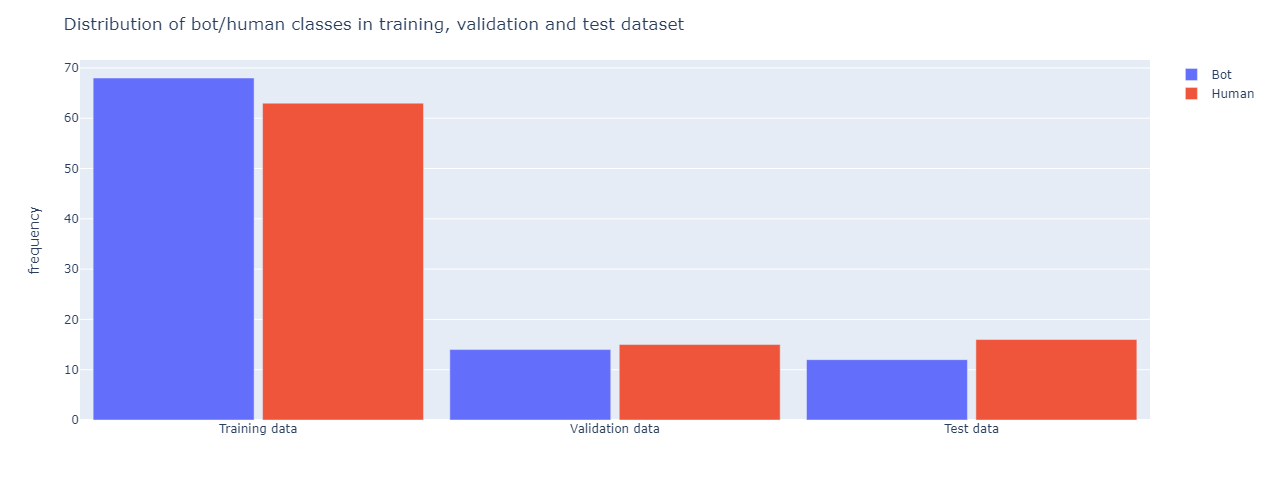

In [180]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']

In [181]:
train_bot_data = train_data.loc[train_data['label']==1]
train_human_data = train_data.loc[train_data['label']==0]

# stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']*4,
#     'Label': ['Bot']*12 + ['Human']*12,
#     'Value': [True]*6 + [False]*6 + [True]*6 + [False]*6,
stack_bool_training_feature_data = {'Feature': ['verified', 'has_pinned_tweet', 'has_description']*4,
    'Label': ['Bot']*6 + ['Human']*6,
    'Value': [True]*3 + [False]*3 + [True]*3 + [False]*3,
    'Freq': [len(train_bot_data.loc[train_bot_data['verified']==1]), 
             # len(train_bot_data.loc[train_bot_data['protected']==1]), 
             # len(train_bot_data.loc[train_bot_data['has_location']==1]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==1]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==1]), 
             len(train_bot_data.loc[train_bot_data['has_description']==1]),
             len(train_bot_data.loc[train_bot_data['verified']==0]), 
             # len(train_bot_data.loc[train_bot_data['protected']==0]), 
             # len(train_bot_data.loc[train_bot_data['has_location']==0]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==0]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==0]), 
             len(train_bot_data.loc[train_bot_data['has_description']==0]),
             len(train_human_data.loc[train_human_data['verified']==1]), 
             # len(train_human_data.loc[train_human_data['protected']==1]), 
             # len(train_human_data.loc[train_human_data['has_location']==1]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==1]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==1]), 
             len(train_human_data.loc[train_human_data['has_description']==1]),
             len(train_human_data.loc[train_human_data['verified']==0]), 
             # len(train_human_data.loc[train_human_data['protected']==0]), 
             # len(train_human_data.loc[train_human_data['has_location']==0]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==0]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==0]), 
             len(train_human_data.loc[train_human_data['has_description']==0])]}

stack_training_bool_feature_df = pd.DataFrame(stack_bool_training_feature_data)

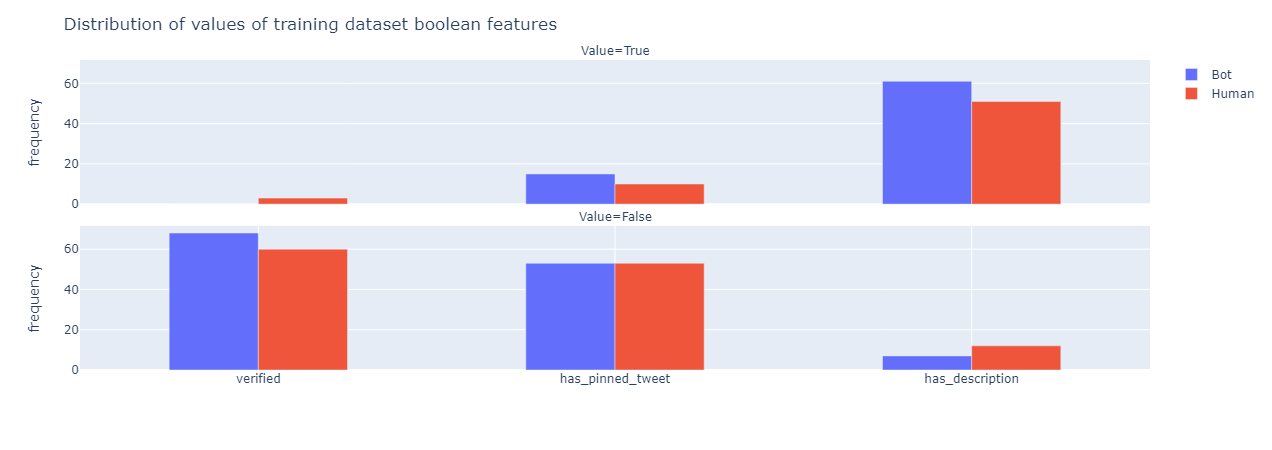

In [182]:
fig = px.bar(stack_training_bool_feature_df, 
               x="Feature", 
               y="Freq",
               facet_col="Value",
               facet_col_wrap = 1,
               color="Label", hover_data=['Label'],
               barmode = 'group')
fig.update_layout(
    title_text='Distribution of values of training dataset boolean features',
    xaxis_title_text='', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True))

fig.update_yaxes(row=2, col=1, title='frequency')
fig.show()

### followers_count

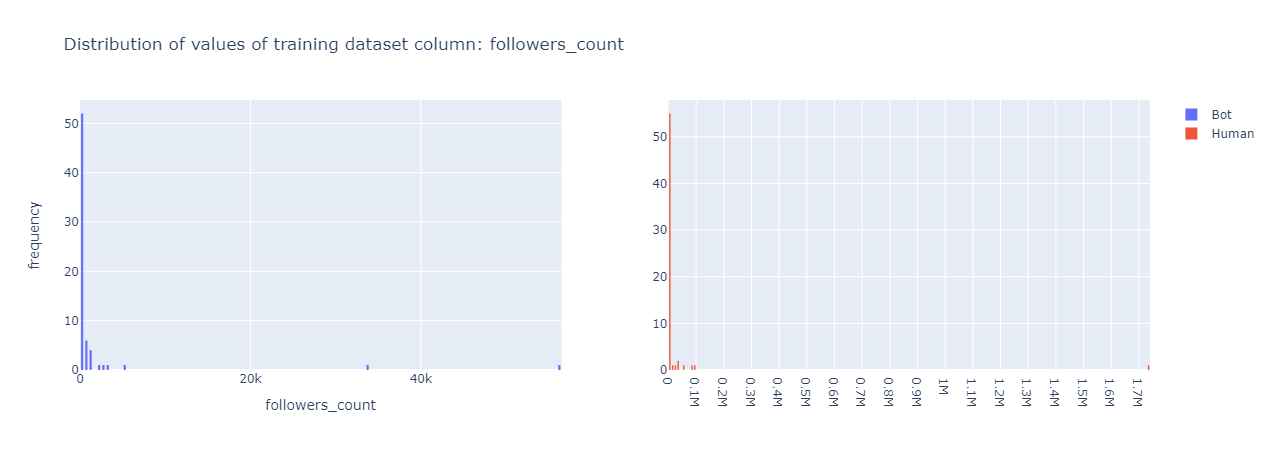

In [183]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=20000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

#### followers_count - outliers

##### K-means (mnonot useful)

Number of outliers:  49


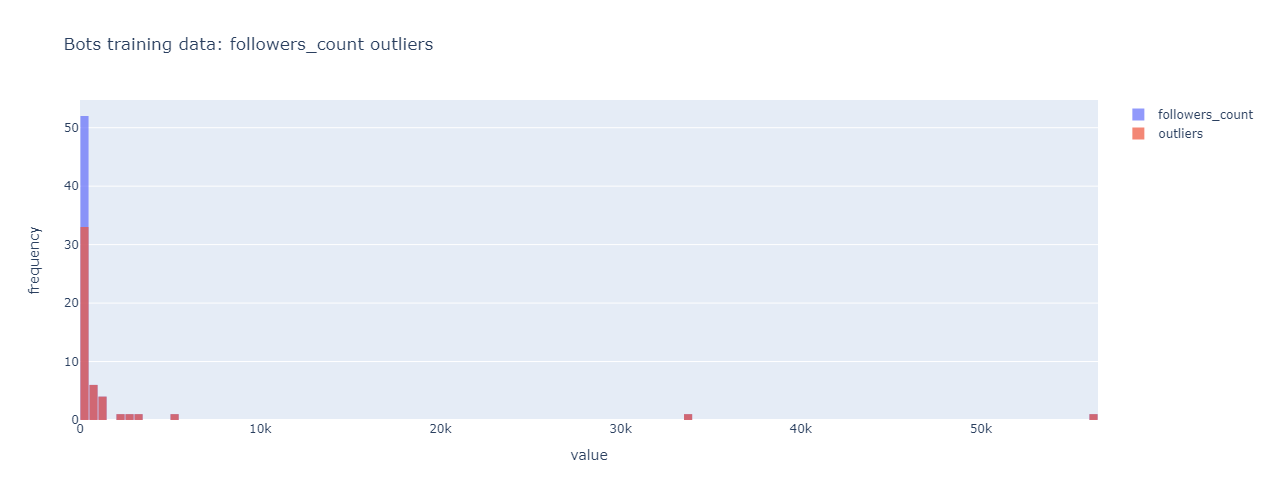

<Figure size 1500x700 with 0 Axes>

In [184]:
followers_count_bots_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==1], 'followers_count', title = "Bots training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

Number of outliers:  44


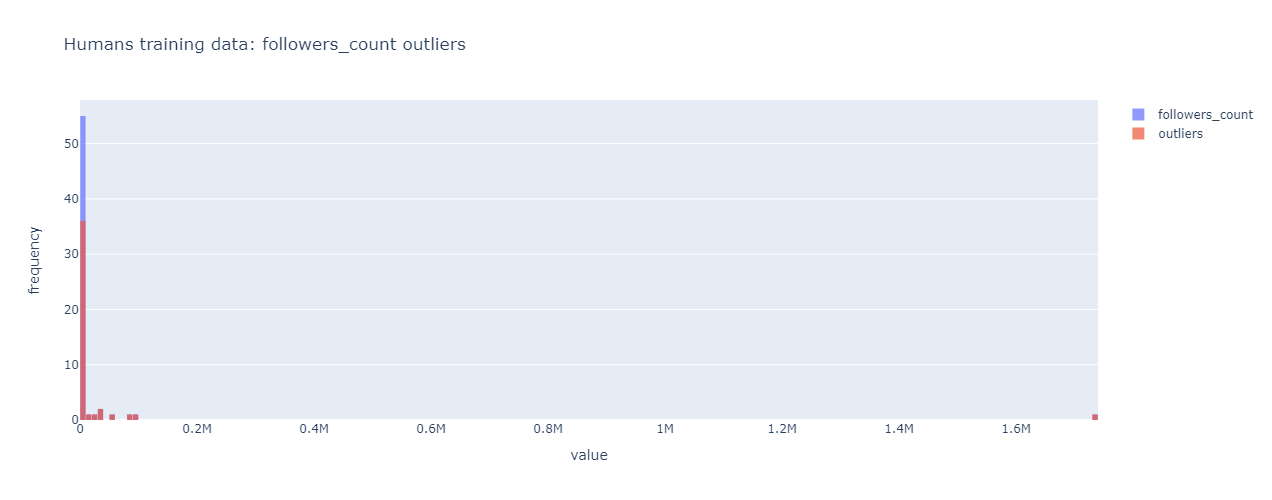

<Figure size 1500x700 with 0 Axes>

In [185]:
followers_count_humans_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==0], 'followers_count', title = "Humans training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [186]:
# q_hi_bots = train_data.loc[train_data['label']==1]['followers_count'].quantile(0.99, interpolation='nearest')
# q_hi_humans = train_data.loc[train_data['label']==0]['followers_count'].quantile(0.99, interpolation='nearest')

# df_filtered_bots = train_data.loc[train_data['label']==1][(train_data.loc[train_data['label']==1]['followers_count'] < q_hi_bots)]
# df_filtered_humans = train_data.loc[train_data['label']==0][(train_data.loc[train_data['label']==0]['followers_count'] < q_hi_humans)]

In [187]:
len(train_data[(train_data['label']==1)])

68

In [188]:
len(train_data[(train_data['label']==0)])

63

In [189]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_data.loc[train_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_data.loc[train_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_data[((train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)) | ((train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_data[(train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_data[(train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans)]

In [190]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

In [191]:
len(df_filtered_bots)

66

In [192]:
len(df_filtered_humans)

62

In [193]:
len(df_reduced_outliers_followers_count) 

128

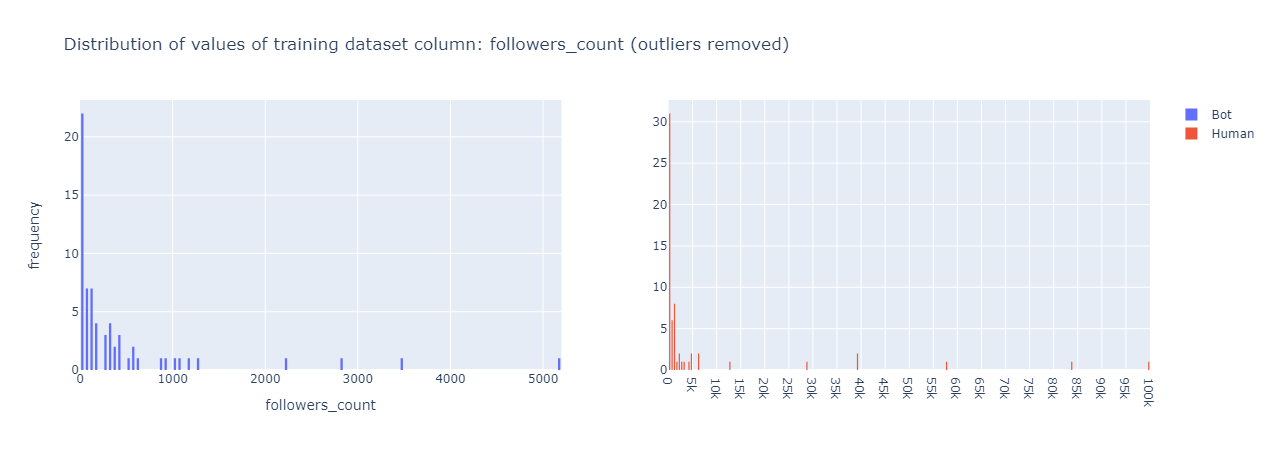

In [194]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count (outliers removed)',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count

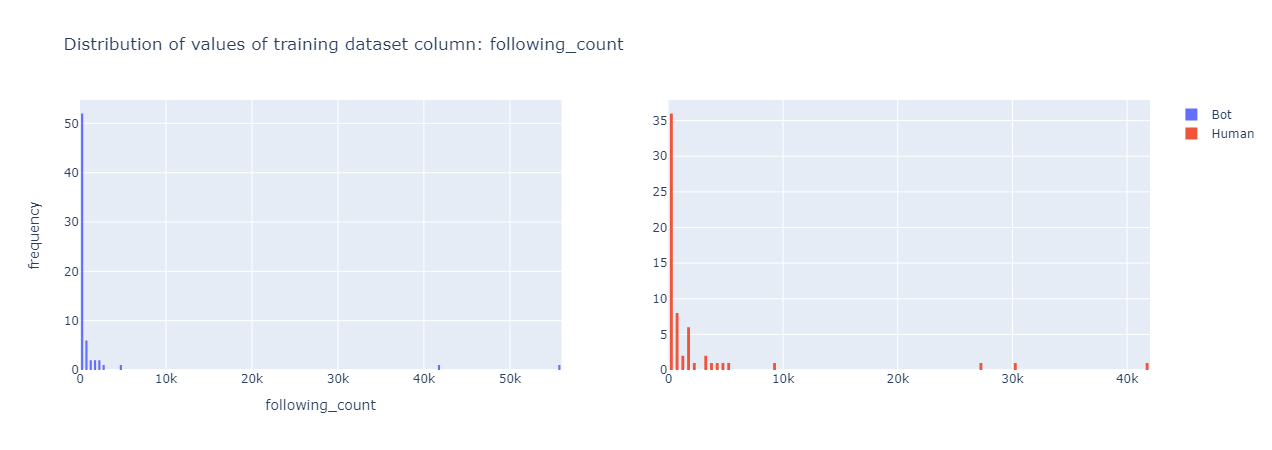

In [195]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000),
    xaxis2=dict(showgrid=True, dtick=10000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count - outliers

In [196]:
df_reduced_outliers_following_count = df_99_percentile(df=train_data, column_name='following_count')

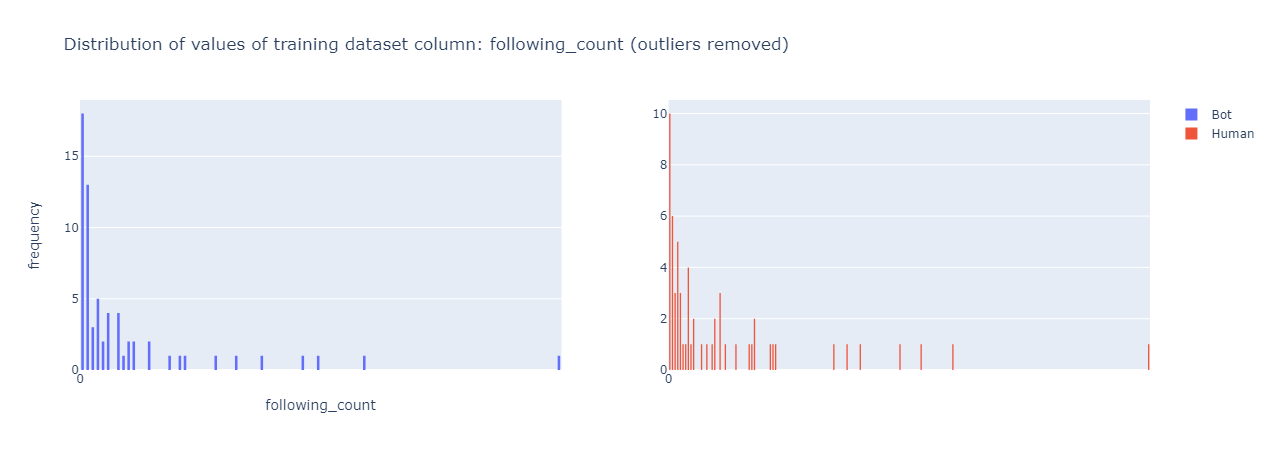

In [197]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count (outliers removed)',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000),
    xaxis2=dict(showgrid=True, dtick=10000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

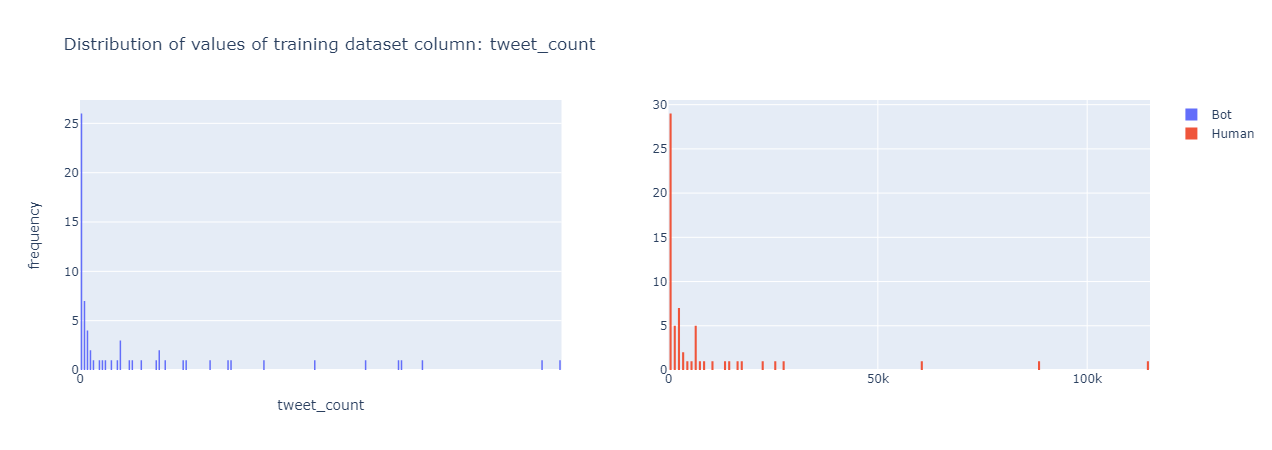

In [198]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=50000),
    xaxis2=dict(showgrid=True, dtick=50000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count - outliers

In [199]:
df_reduced_outliers_tweet_count = df_99_percentile(df=train_data, column_name='tweet_count')

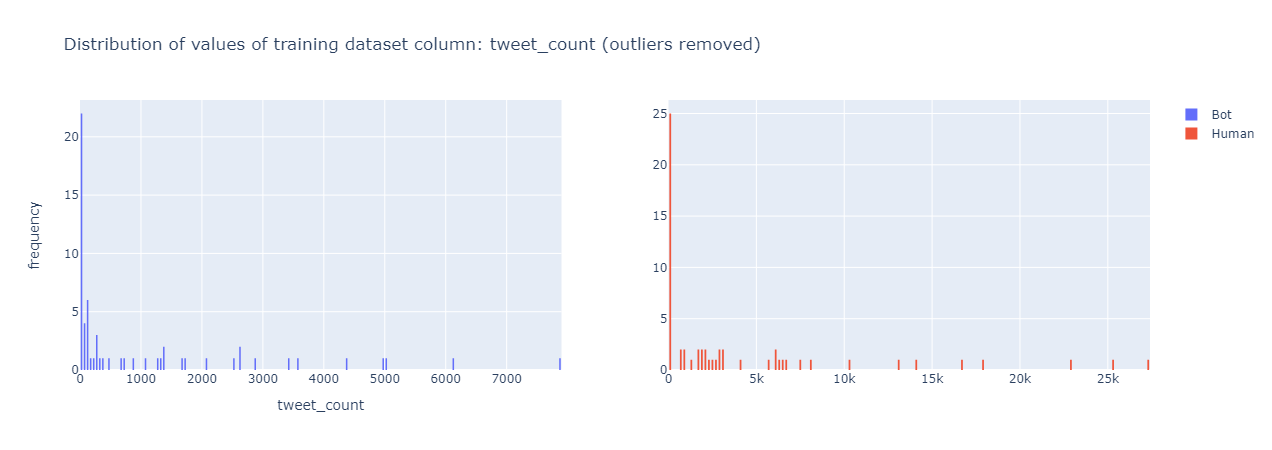

In [200]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count (outliers removed)',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

### listed_count

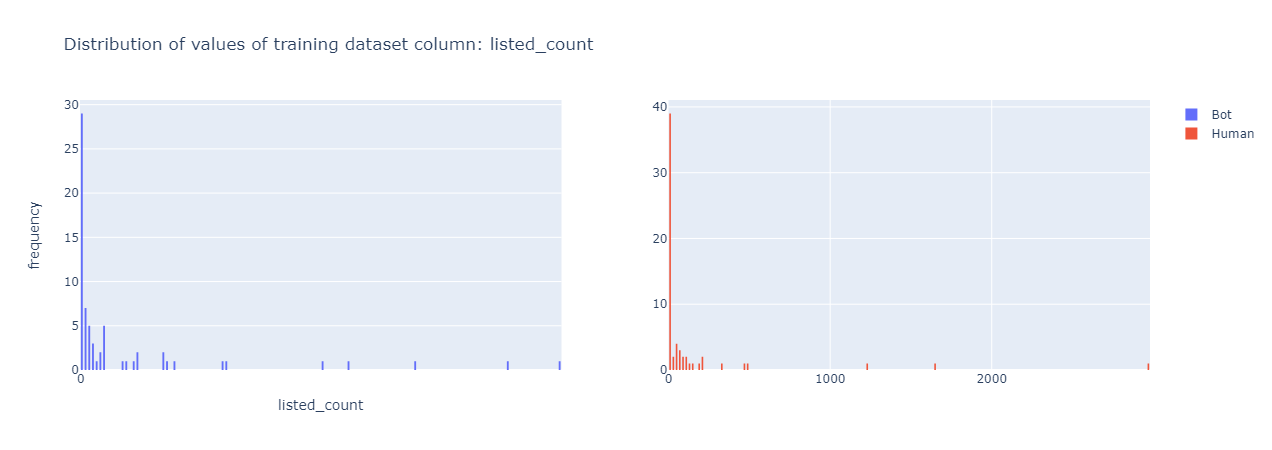

In [201]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=1000),
    yaxis=dict(showgrid=True))

fig.show()

#### listed_count - outliers

In [202]:
df_reduced_outliers_listed_count = df_99_percentile(df=train_data, column_name='listed_count')

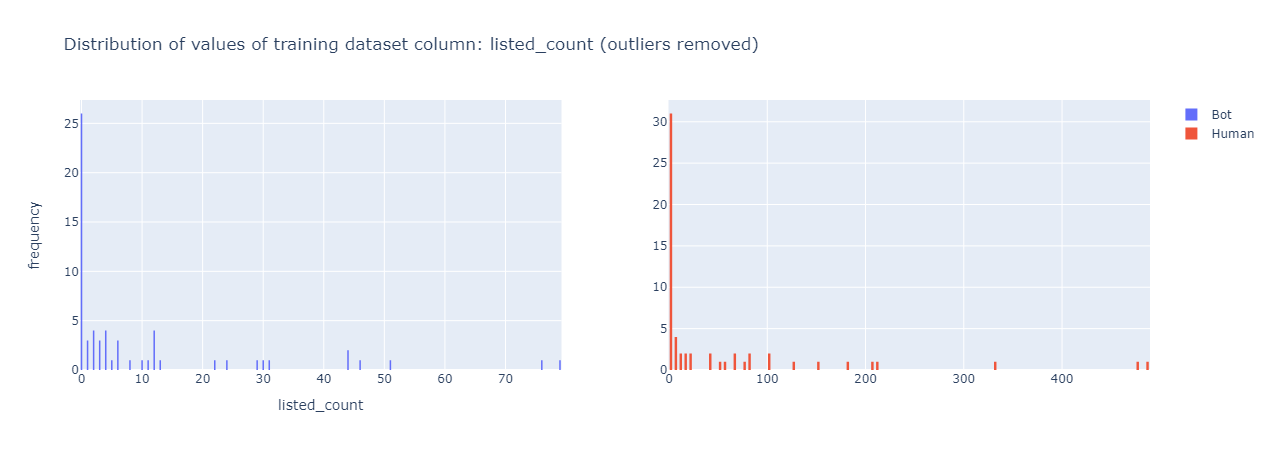

In [203]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count (outliers removed)',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=100),
    yaxis=dict(showgrid=True))

fig.show()

### ['descr_no_hashtags', 'descr_no_cashtags', 'descr_no_mentions', 'descr_no_urls', 'descr_len', 'url_no_urls']

### descr_no_hashtags

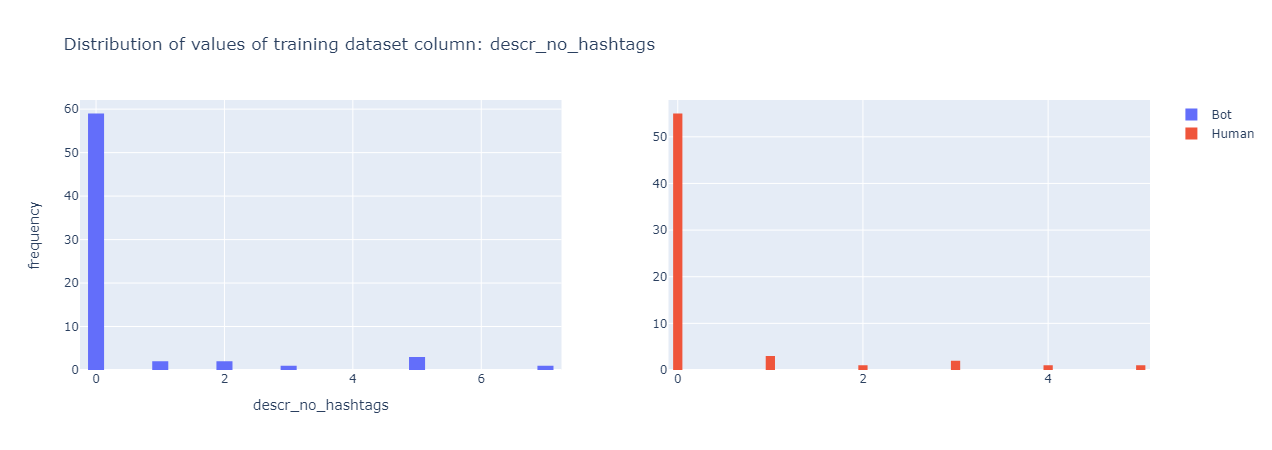

In [204]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=2),
    xaxis2=dict(showgrid=True, dtick=2),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_hashtags - outliers

In [205]:
df_reduced_outliers_descr_no_hashtags = df_99_percentile(df=train_data, column_name='descr_no_hashtags')

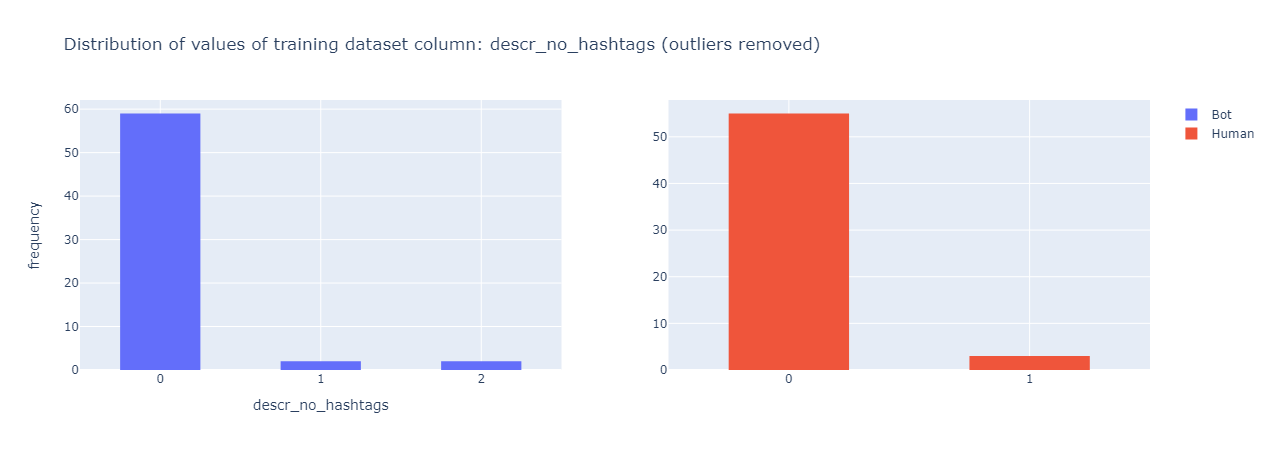

In [206]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags (outliers removed)',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_cashtags


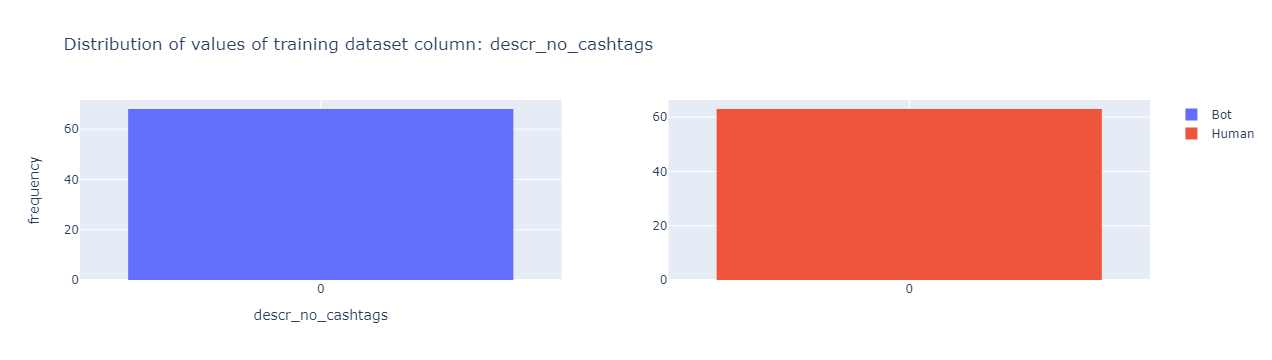

In [207]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_cashtags - outliers

In [208]:
df_reduced_outliers_descr_no_cashtags = df_99_percentile(df=train_data, column_name='descr_no_cashtags')

/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning:

invalid value encountered in multiply



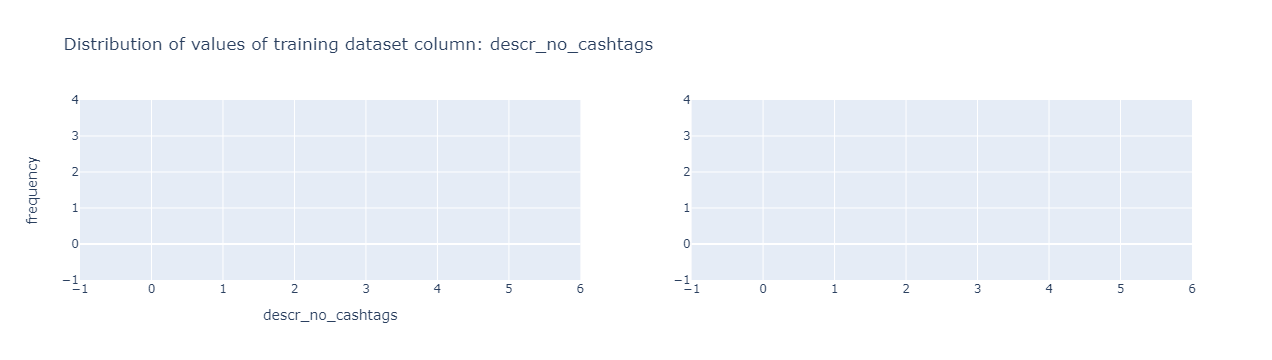

In [209]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### descr_no_mentions

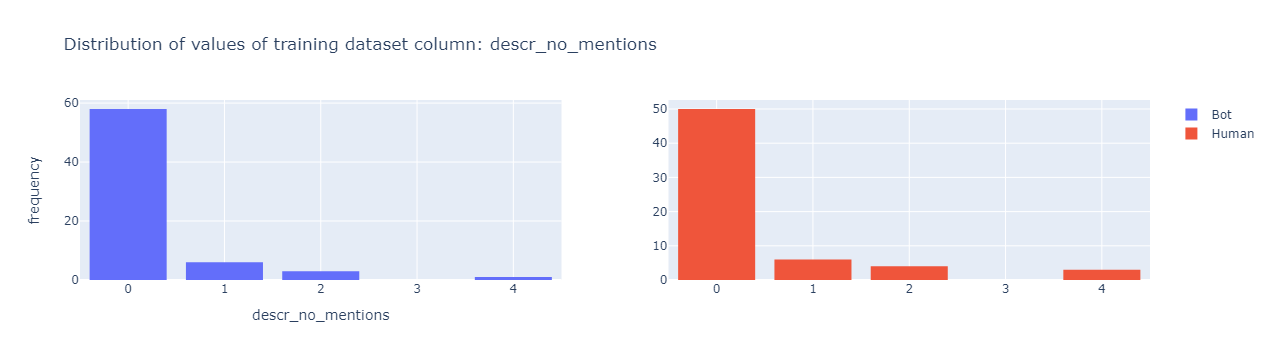

In [210]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_mentions - outliers

In [211]:
df_reduced_outliers_descr_no_mentions = df_99_percentile(df=train_data, column_name='descr_no_mentions')

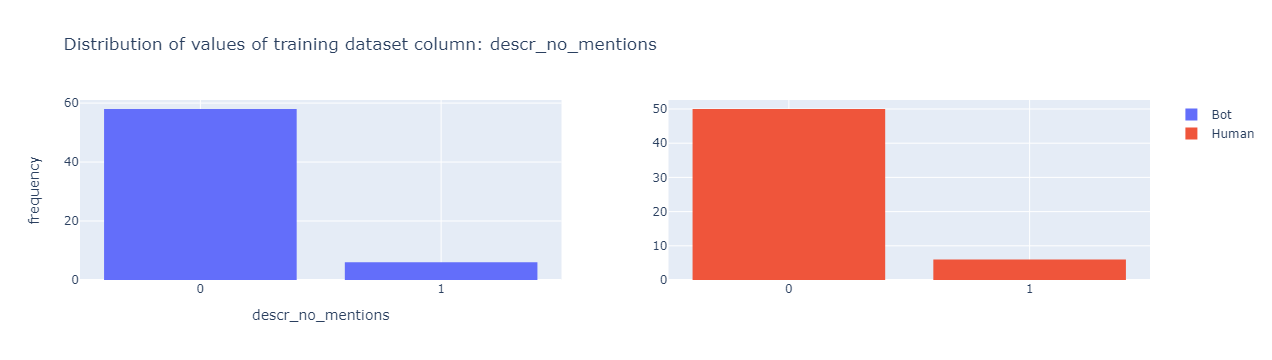

In [212]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_urls

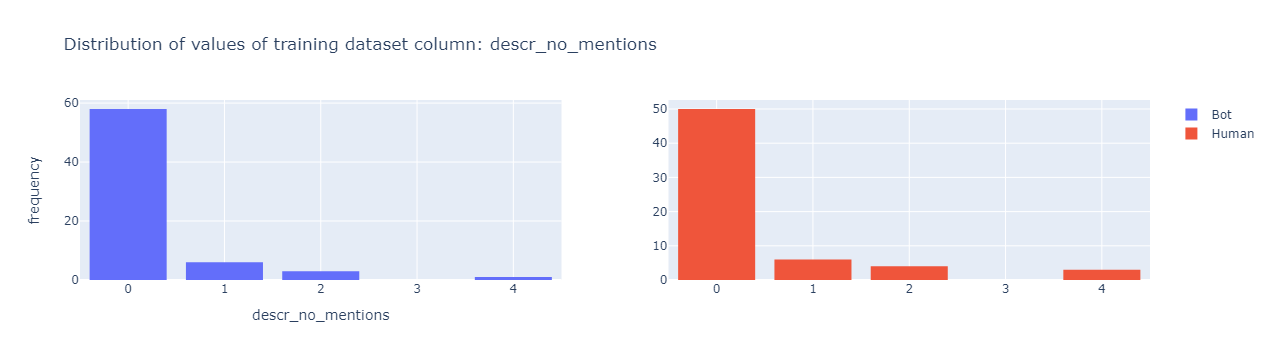

In [213]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_urls - outliers

In [214]:
df_reduced_outliers_descr_no_urls = df_99_percentile(df=train_data, column_name='descr_no_urls')

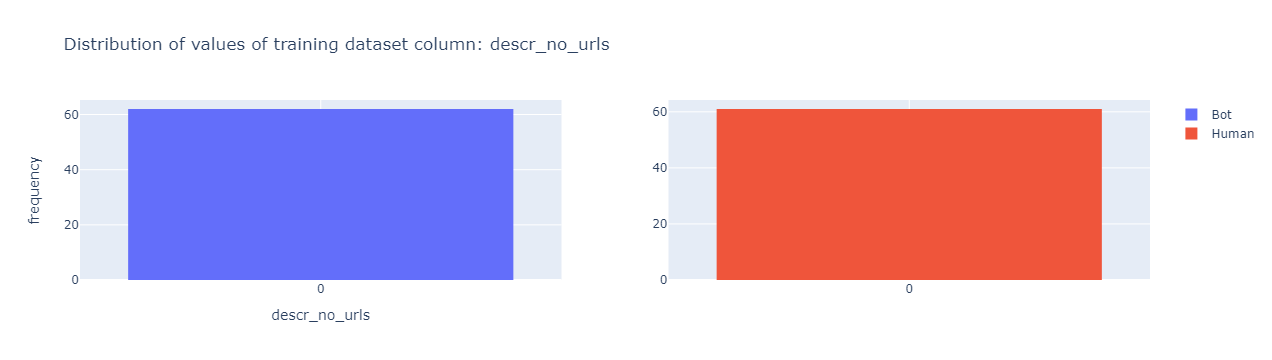

In [215]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==1,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==0,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_urls',
    xaxis_title_text='descr_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### url_no_urls

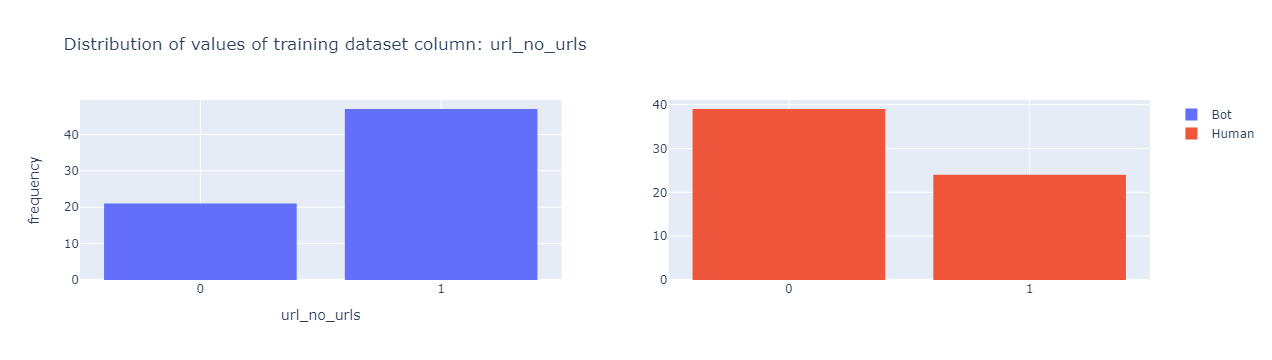

In [216]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### url_no_urls - outliers

In [217]:
df_reduced_outliers_url_no_urls = df_99_percentile(df=train_data, column_name='url_no_urls')

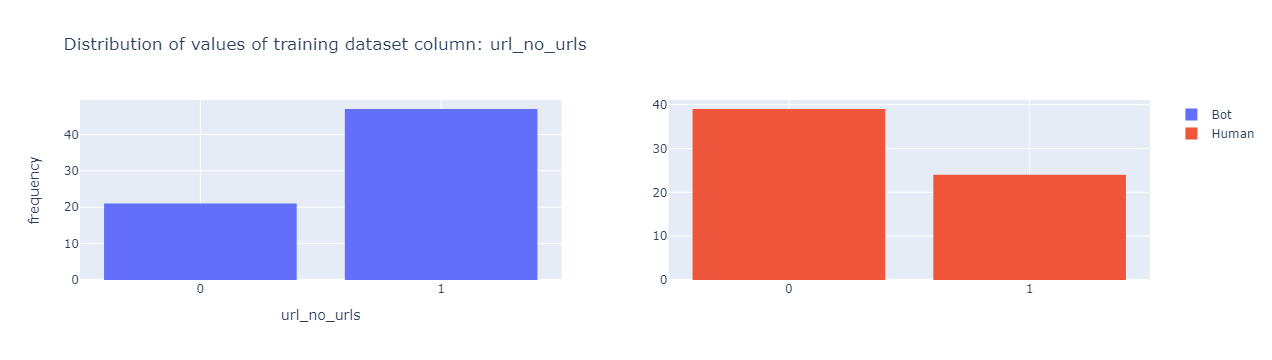

In [218]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

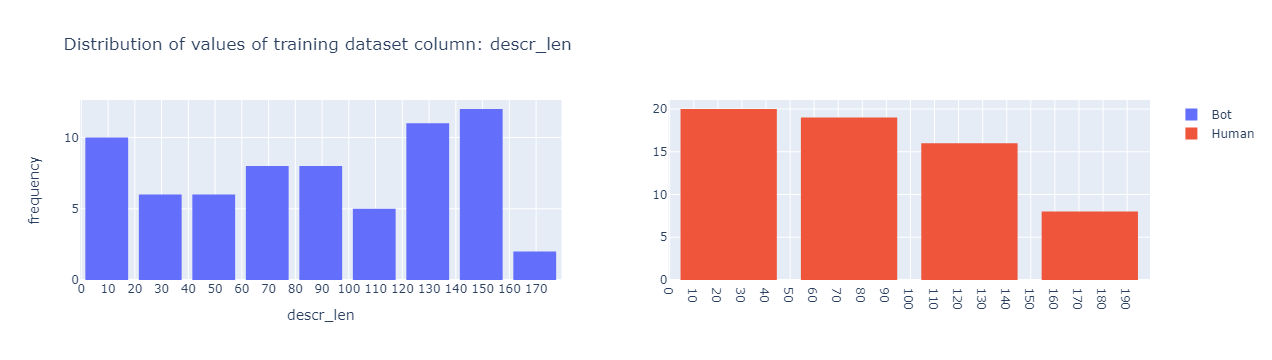

In [219]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers

In [220]:
q_hi_bots1 = train_data.loc[train_data['label']==1]['descr_len'].quantile(0.99, interpolation='nearest')
q_hi_humans1 = train_data.loc[train_data['label']==0]['descr_len'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_descr_len =  train_data[((train_data['label']==1) & (train_data['descr_len'] < q_hi_bots1)) | ((train_data['label']==0) & (train_data['descr_len'] < q_hi_humans1))]

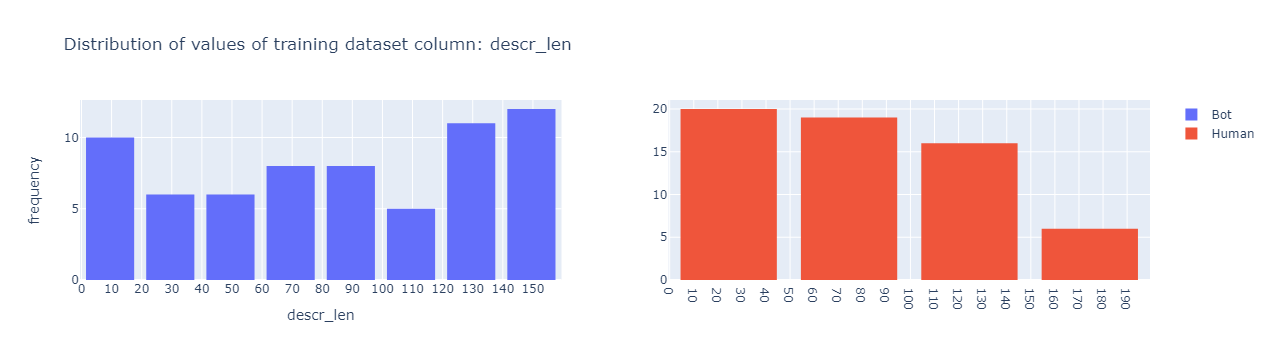

In [221]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers (outdated version)

In [222]:
# df_reduced_outliers_descr_len = df_99_percentile(df=train_data, column_name='descr_len')

In [223]:
# fig = go.Figure()
# fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

# fig.add_trace(go.Histogram(
#     x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
#     # histnorm='density',
#     # nbinsx=30,
#     name='Bot'),
# row=1, col=1
# )
# fig.add_trace(go.Histogram(
#     x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
#     # histnorm='density',
#     # nbinsx=30,
#     name='Human'),
# row=1, col=2
# )

# fig.update_layout(
#     title_text='Distribution of values of training dataset column: descr_len',
#     xaxis_title_text='descr_len', #'feature',
#     yaxis_title_text='frequency',
#     bargap=0.2,
#     bargroupgap=None, #0.8,
#     width=1100,
#     height=350,
#     legend={"title":""},
#     xaxis=dict(showgrid=True, dtick=10),
#     xaxis2=dict(showgrid=True, dtick=10),
#     yaxis=dict(showgrid=True))

# fig.show()

### account_age

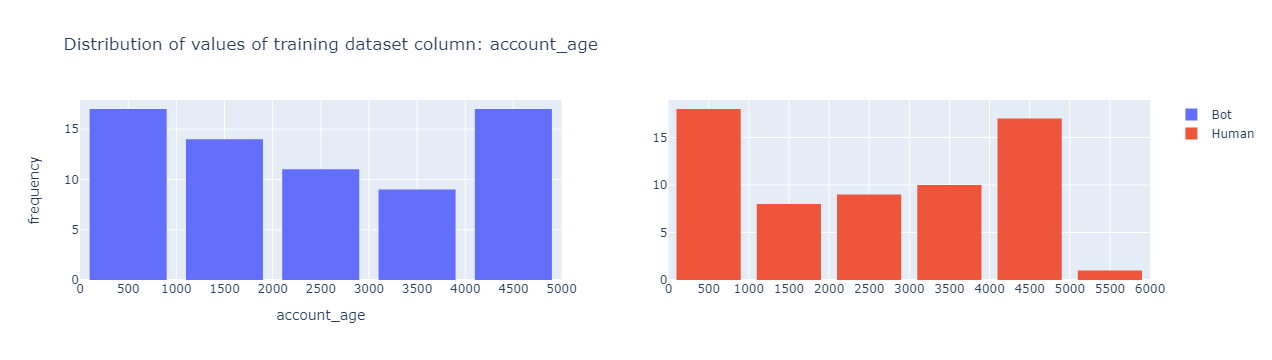

In [224]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500),
    xaxis2=dict(showgrid=True, dtick=500),
    yaxis=dict(showgrid=True))

fig.show()

#### account_age - outliers

In [225]:
q_hi_bots2 = train_data.loc[train_data['label']==1]['account_age'].quantile(0.99, interpolation='nearest')
q_hi_humans2 = train_data.loc[train_data['label']==0]['account_age'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_account_age =  train_data[((train_data['label']==1) & (train_data['account_age'] < q_hi_bots2)) | ((train_data['label']==0) & (train_data['account_age'] < q_hi_humans2))]

### country_numeric

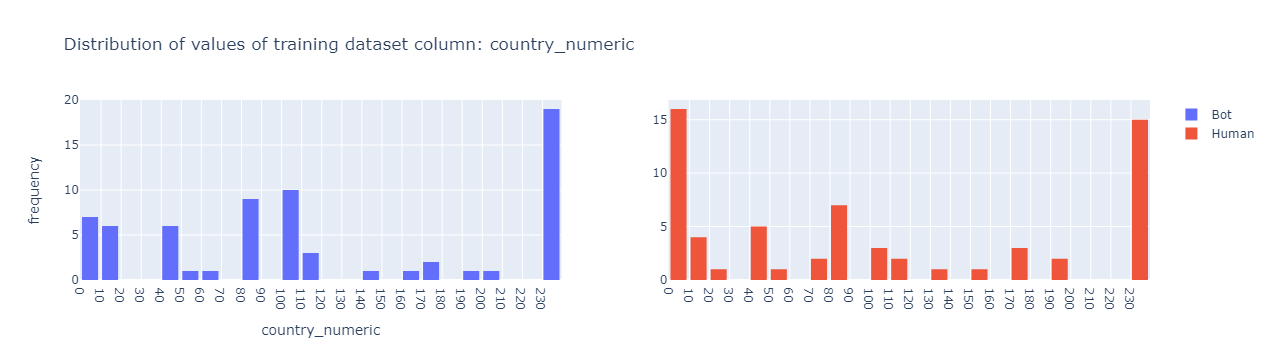

In [226]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'country_numeric'],
    # histnorm='density',
    nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'country_numeric'],
    # histnorm='density',
    nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: country_numeric',
    xaxis_title_text='country_numeric', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### country_numeric - outliers

In [227]:
df_reduced_outliers_country_numeric = df_99_percentile(df=train_data, column_name='country_numeric')

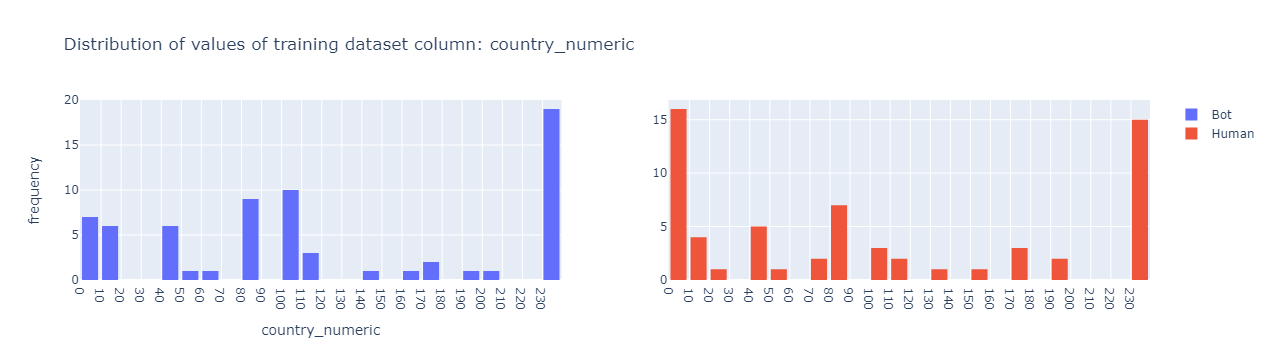

In [228]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_country_numeric.loc[df_reduced_outliers_country_numeric['label']==1,'country_numeric'],
    # histnorm='density',
    nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_country_numeric.loc[df_reduced_outliers_country_numeric['label']==0,'country_numeric'],
    # histnorm='density',
    nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: country_numeric',
    xaxis_title_text='country_numeric', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

### Create merged dataframe from reduced by columns outliers dataframes

In [229]:
# train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_tweet_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_listed_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_hashtags, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# # train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_cashtags, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_mentions, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_urls, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_url_no_urls, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_len, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_account_age, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_country_numeric, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [ ]:
train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

rest_of_df = [df_reduced_outliers_tweet_count, 
              df_reduced_outliers_listed_count, 
              df_reduced_outliers_descr_no_hashtags, 
              df_reduced_outliers_descr_no_cashtags,
              df_reduced_outliers_descr_no_mentions,
              df_reduced_outliers_descr_no_urls,
              df_reduced_outliers_url_no_urls,
              df_reduced_outliers_descr_len,
              df_reduced_outliers_account_age,
              df_reduced_outliers_country_numeric]

for df in rest_of_df:
    if (len(df.loc[df['label']==1]) > 0 and len(df.loc[df['label']==0]) > 0):
        train_data_wo_outliers = train_data_wo_outliers.merge(df, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [230]:
len(train_data_wo_outliers)

89

In [232]:
train_data_wo_outliers

id  label  verified  protected  has_pinned_tweet  \
0   7.409416e+17    1.0       0.0        0.0               0.0   
1   1.339962e+08    1.0       0.0        0.0               0.0   
2   2.324969e+08    0.0       0.0        0.0               0.0   
3   1.878592e+08    1.0       0.0        0.0               0.0   
4   1.175146e+18    1.0       0.0        0.0               1.0   
5   1.164284e+18    0.0       0.0        1.0               0.0   
6   1.279726e+18    1.0       0.0        0.0               0.0   
7   1.239706e+18    0.0       0.0        0.0               0.0   
8   1.413490e+18    1.0       0.0        0.0               0.0   
9   1.447957e+18    0.0       0.0        0.0               0.0   
10  1.478792e+18    0.0       0.0        0.0               0.0   
11  1.241525e+08    0.0       0.0        0.0               0.0   
12  1.206788e+18    1.0       0.0        0.0               1.0   
13  1.186743e+18    0.0       0.0        0.0               1.0   
14  1.240361e+18    0.0       0.0        0.0               0.0   
15  8.417120e+17    0.0       0.0        0.0               0.0   
16  1.463139e+18    1.0       0.0        0.0               0.0   
17  1.138441e+18    1.0       0.0        0.0               0.0   
18  2.707806e+07    1.0       0.0        0.0               0.0   
19  3.632505e+08    0.0       0.0        0.0               0.0   
20  1.401299e+09    0.0       0.0        0.0               0.0   
21  3.882305e+07    0.0       0.0        0.0               0.0   
22  1.282536e+18    1.0       0.0        0.0               0.0   
23  1.367325e+18    0.0       0.0        0.0               1.0   
24  6.337677e+08    0.0       0.0        0.0               0.0   
25  4.378488e+09    1.0       0.0        0.0               0.0   
26  1.249716e+18    1.0       0.0        0.0               0.0   
27  1.302875e+18    0.0       0.0        0.0               0.0   
28  1.259796e+18    1.0       0.0        0.0               0.0   
29  3.816420e+07    1.0       0.0        0.0               0.0   
30  1.044743e+18    1.0       0.0        0.0               0.0   
31  1.114199e+18    0.0       0.0        0.0               1.0   
32  1.391779e+18    0.0       0.0        0.0               0.0   
33  9.301367e+17    1.0       0.0        0.0               0.0   
34  8.825649e+17    1.0       0.0        0.0               0.0   
35  3.431402e+09    0.0       0.0        0.0               0.0   
36  7.381117e+17    0.0       0.0        0.0               0.0   
37  1.205275e+18    0.0       0.0        0.0               0.0   
38  3.029784e+07    0.0       0.0        0.0               0.0   
39  1.347232e+09    1.0       0.0        0.0               0.0   
40  1.481891e+18    0.0       0.0        0.0               0.0   
41  8.608085e+08    1.0       0.0        0.0               0.0   
42  8.117255e+07    0.0       0.0        0.0               0.0   
43  2.332454e+09    1.0       0.0        0.0               0.0   
44  1.417221e+08    0.0       0.0        0.0               0.0   
45  1.571273e+09    1.0       0.0        0.0               0.0   
46  5.078825e+07    1.0       0.0        0.0               0.0   
47  2.877747e+09    0.0       0.0        0.0               0.0   
48  1.484544e+18    0.0       0.0        0.0               0.0   
49  1.659154e+08    0.0       0.0        0.0               1.0   
50  1.858018e+09    0.0       0.0        0.0               0.0   
51  3.278532e+07    1.0       0.0        0.0               1.0   
52  3.349069e+08    0.0       0.0        0.0               0.0   
53  2.459428e+08    0.0       0.0        0.0               0.0   
54  4.646429e+07    1.0       0.0        0.0               0.0   
55  9.264518e+17    0.0       0.0        0.0               0.0   
56  1.279443e+08    0.0       1.0        0.0               0.0   
57  1.463754e+18    0.0       0.0        0.0               0.0   
58  9.309307e+08    0.0       0.0        0.0               0.0   
59  2.732274e+09    0.0       0.0        0.0          

#### Drop 'id' column

In [233]:
train_data = train_data.drop(['id'], axis=1)
val_data = val_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

train_data_wo_outliers = train_data_wo_outliers.drop(['id'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['id'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['id'], axis=1)

### Filter to have the same number of records for each class - part II

In [234]:
train_data = filter_df_for_balanced_classes(train_data, bot_label_value=1, human_label_value=0)
val_data = filter_df_for_balanced_classes(val_data, bot_label_value=1, human_label_value=0)
test_data = filter_df_for_balanced_classes(test_data, bot_label_value=1, human_label_value=0)

Number of bots:  63
Number of human users:  63
Number of bots:  14
Number of human users:  14
Number of bots:  12
Number of human users:  12


In [235]:
train_data_wo_outliers = filter_df_for_balanced_classes(train_data_wo_outliers, bot_label_value=1, human_label_value=0)
val_data_wo_outliers = filter_df_for_balanced_classes(val_data_wo_outliers, bot_label_value=1, human_label_value=0)
test_data_wo_outliers = filter_df_for_balanced_classes(test_data_wo_outliers, bot_label_value=1, human_label_value=0)

Number of bots:  44
Number of human users:  44
Number of bots:  14
Number of human users:  14
Number of bots:  12
Number of human users:  12


## Correlation

In [236]:
sns.set(font_scale=2)

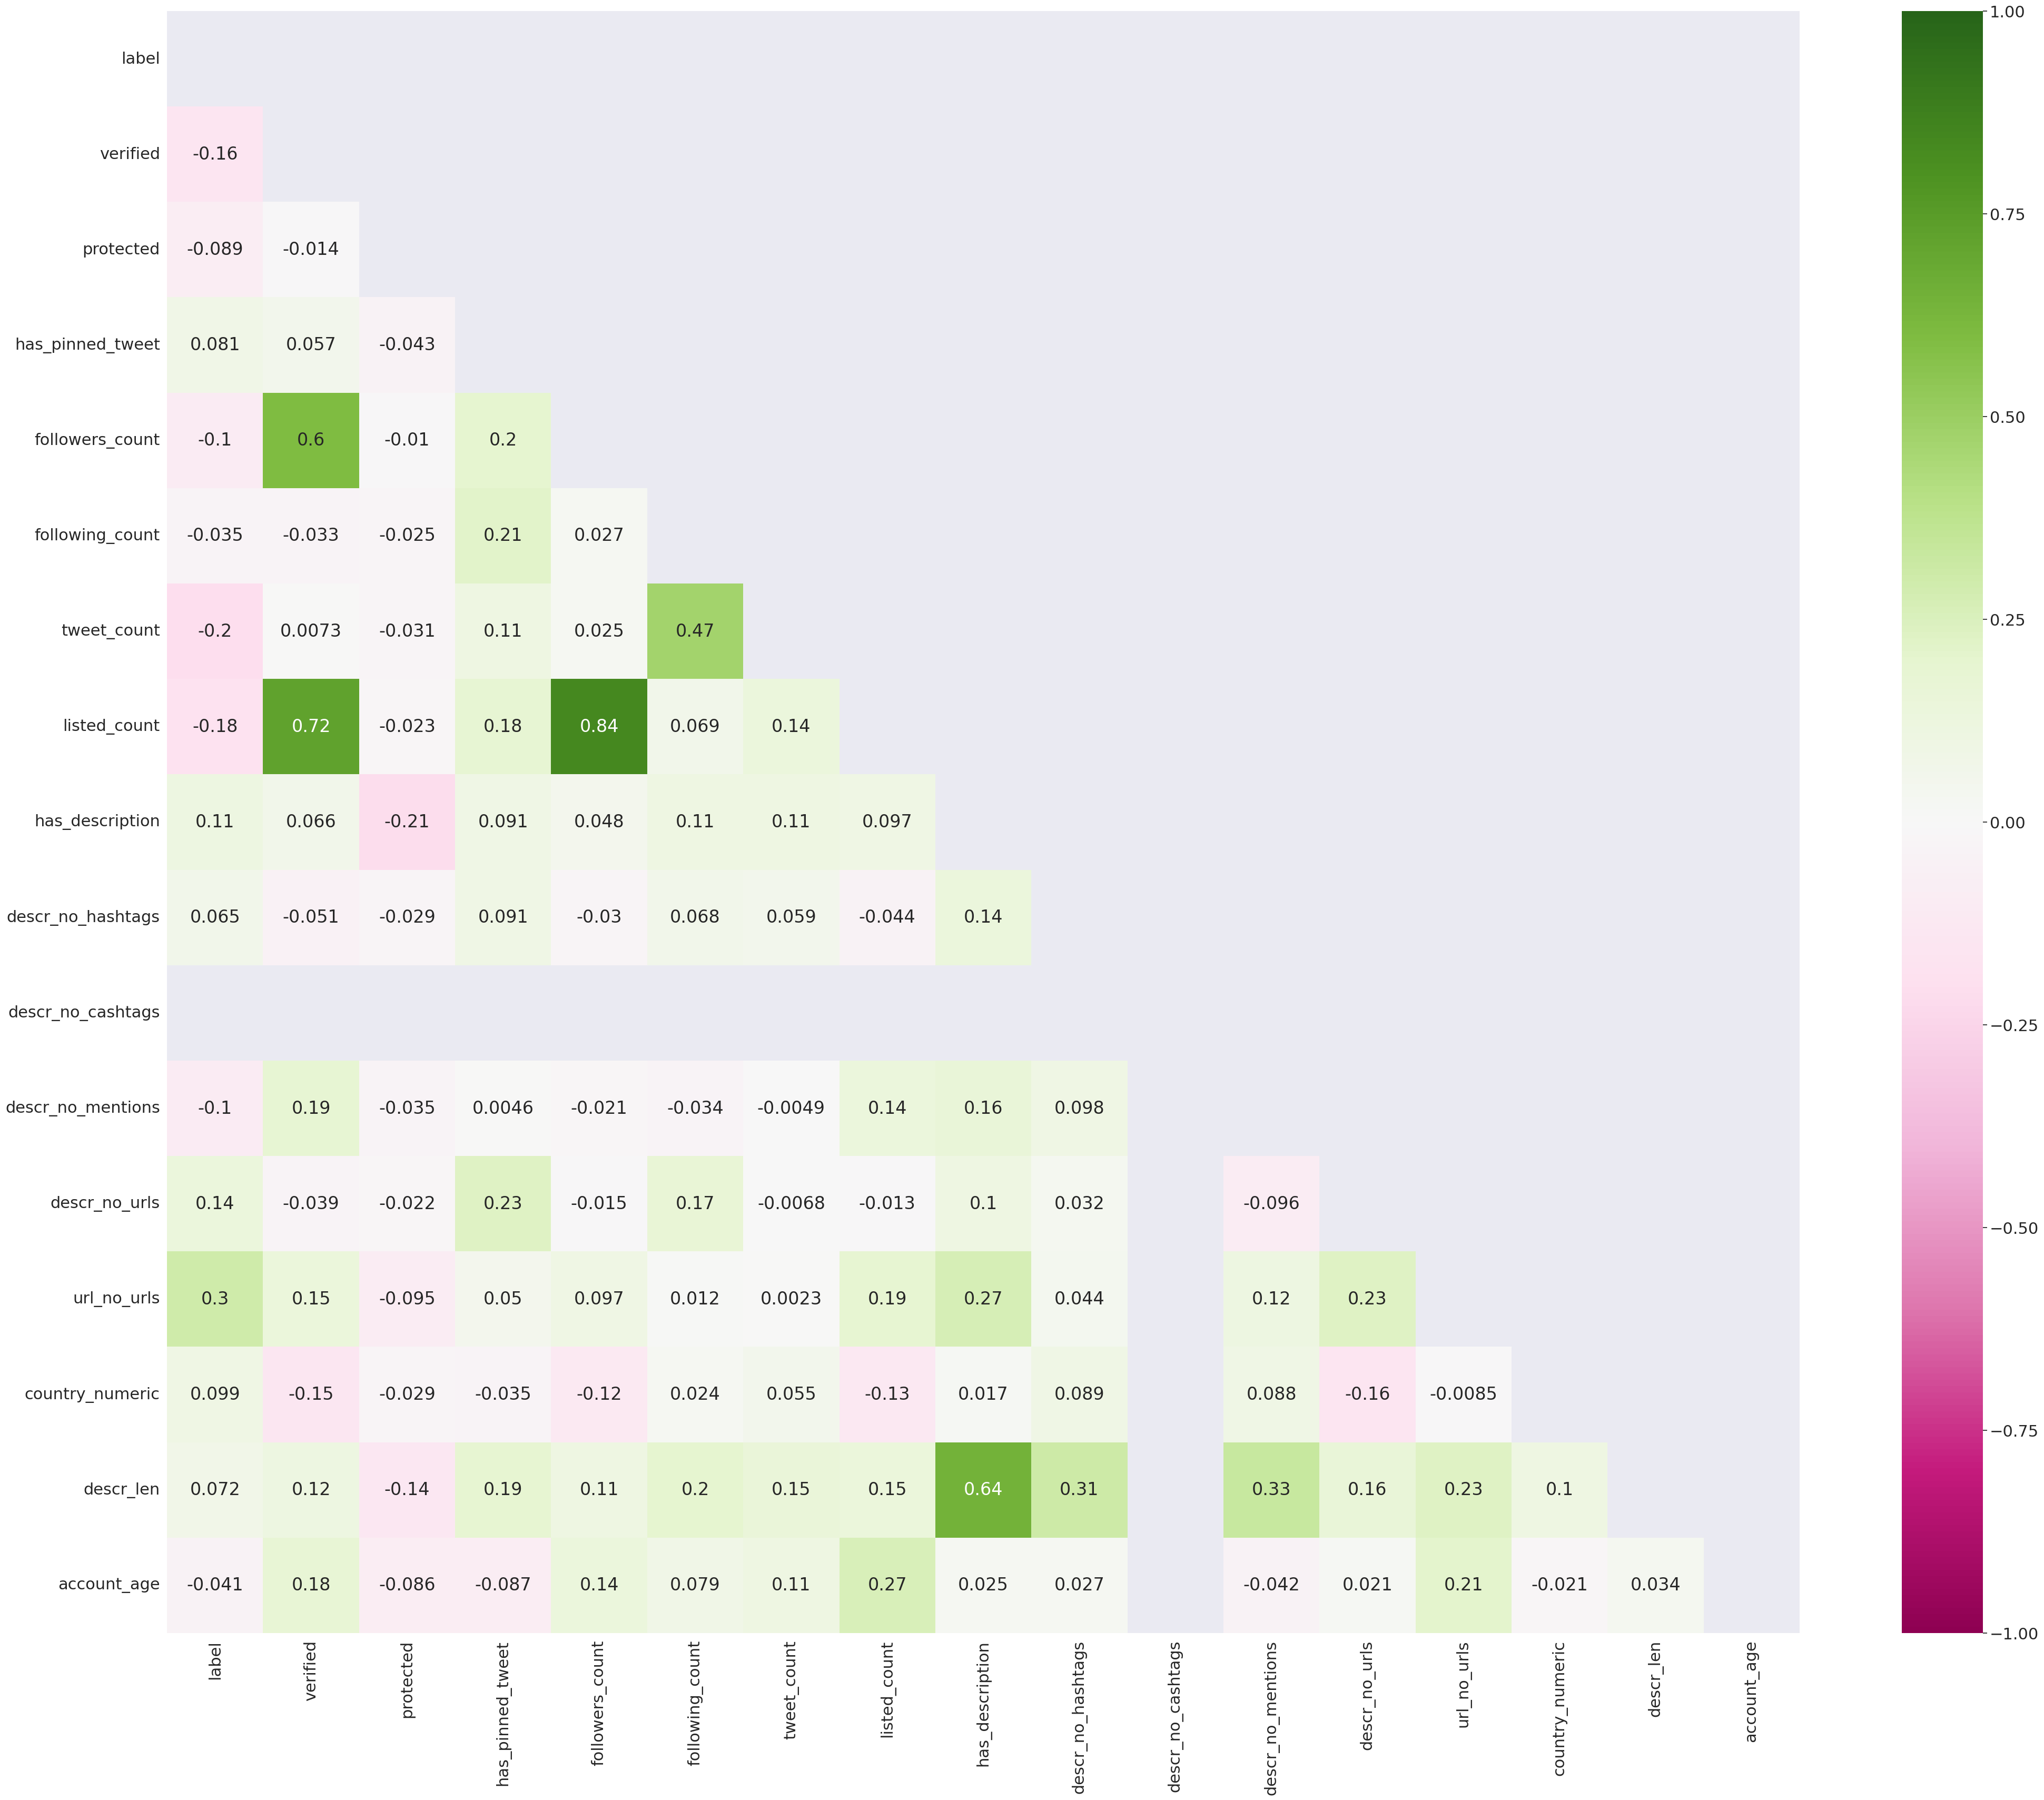

In [237]:
corr_threshold = 0.52
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [238]:
sns.set(font_scale=1)

In [241]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 3


[('followers_count', 'listed_count', 0.8422013325682983),
 ('verified', 'listed_count', 0.7192940005428753),
 ('has_description', 'descr_len', 0.642783812201641),
 ('verified', 'followers_count', 0.5971338388572971)]

In [242]:
train_data

label  verified  protected  has_pinned_tweet  followers_count  \
272    1.0       0.0        0.0               0.0            435.0   
38     1.0       0.0        0.0               0.0            342.0   
413    1.0       0.0        0.0               1.0            334.0   
261    1.0       0.0        0.0               0.0            517.0   
82     0.0       0.0        0.0               0.0             41.0   
..     ...       ...        ...               ...              ...   
280    1.0       0.0        0.0               1.0           2207.0   
199    1.0       0.0        0.0               1.0             50.0   
118    0.0       0.0        0.0               0.0          39462.0   
61     0.0       0.0        0.0               0.0           2055.0   
62     0.0       0.0        0.0               0.0              4.0   

     following_count  tweet_count  listed_count  has_description  \
272            509.0        857.0           5.0              1.0   
38             160.0       1696.0          79.0              1.0   
413            375.0        112.0           0.0              1.0   
261            414.0        303.0           2.0              1.0   
82             109.0         14.0           1.0              1.0   
..               ...          ...           ...              ...   
280           2761.0      10760.0         231.0              1.0   
199            108.0       2625.0           1.0              1.0   
118          30268.0      60908.0         489.0              1.0   
61            1525.0      10225.0          23.0              0.0   
62             153.0          2.0           0.0              1.0   

     descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
272                0.0                0.0                0.0            0.0   
38                 7.0                0.0                1.0            0.0   
413                0.0                0.0                2.0            0.0   
261                0.0                0.0                0.0            0.0   
82                 0.0                0.0                0.0            0.0   
..                 ...                ...                ...            ...   
280                0.0                0.0                1.0            0.0   
199                0.0                0.0                0.0            0.0   
118                0.0                0.0                1.0            0.0   
61                 0.0                0.0                0.0            0.0   
62                 0.0                0.0                0.0            0.0   

     url_no_urls  country_numeric  descr_len  account_age  
272          1.0            108.0      139.0       2106.0  
38           1.0            148.0      160.0       4433.0  
413          1.0            236.0      156.0        277.0  
261          1.0            236.0      159.0       4351.0  
82           0.0             81.0       84.0       4093.0  
..           ...              ...        ...          ...  
280          1.0            236.0      158.0       3327.0  
199          1.0            106.0      153.0       1094.0  
118          0.0            236.0      153.0       2961.0  
61           0.0              1.0        0.0       1602.0  
62           0.0              1.0       24.0       1588.0  

[126 rows x 17 columns]

In [243]:
train_data = train_data.drop(['listed_count'], axis=1)
val_data = val_data.drop(['listed_count'], axis=1)
test_data = test_data.drop(['listed_count'], axis=1)

train_data = train_data.drop(['has_description'], axis=1)
val_data = val_data.drop(['has_description'], axis=1)
test_data = test_data.drop(['has_description'], axis=1)

### Correlation of data reduced by outliers

#### First drop columns in filter (without outliers) dataframe where now have same value in whole column

In [244]:
same_data_columns = list(train_data_wo_outliers.columns[train_data_wo_outliers.apply(lambda x: x.nunique()) == 1])
same_data_columns

['descr_no_cashtags', 'descr_no_urls']

In [245]:
train_data_wo_outliers = train_data_wo_outliers.drop(same_data_columns, axis=1)

val_data_wo_outliers = val_data_wo_outliers.drop(same_data_columns, axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(same_data_columns, axis=1)

#### Correlation

In [246]:
sns.set(font_scale=2)

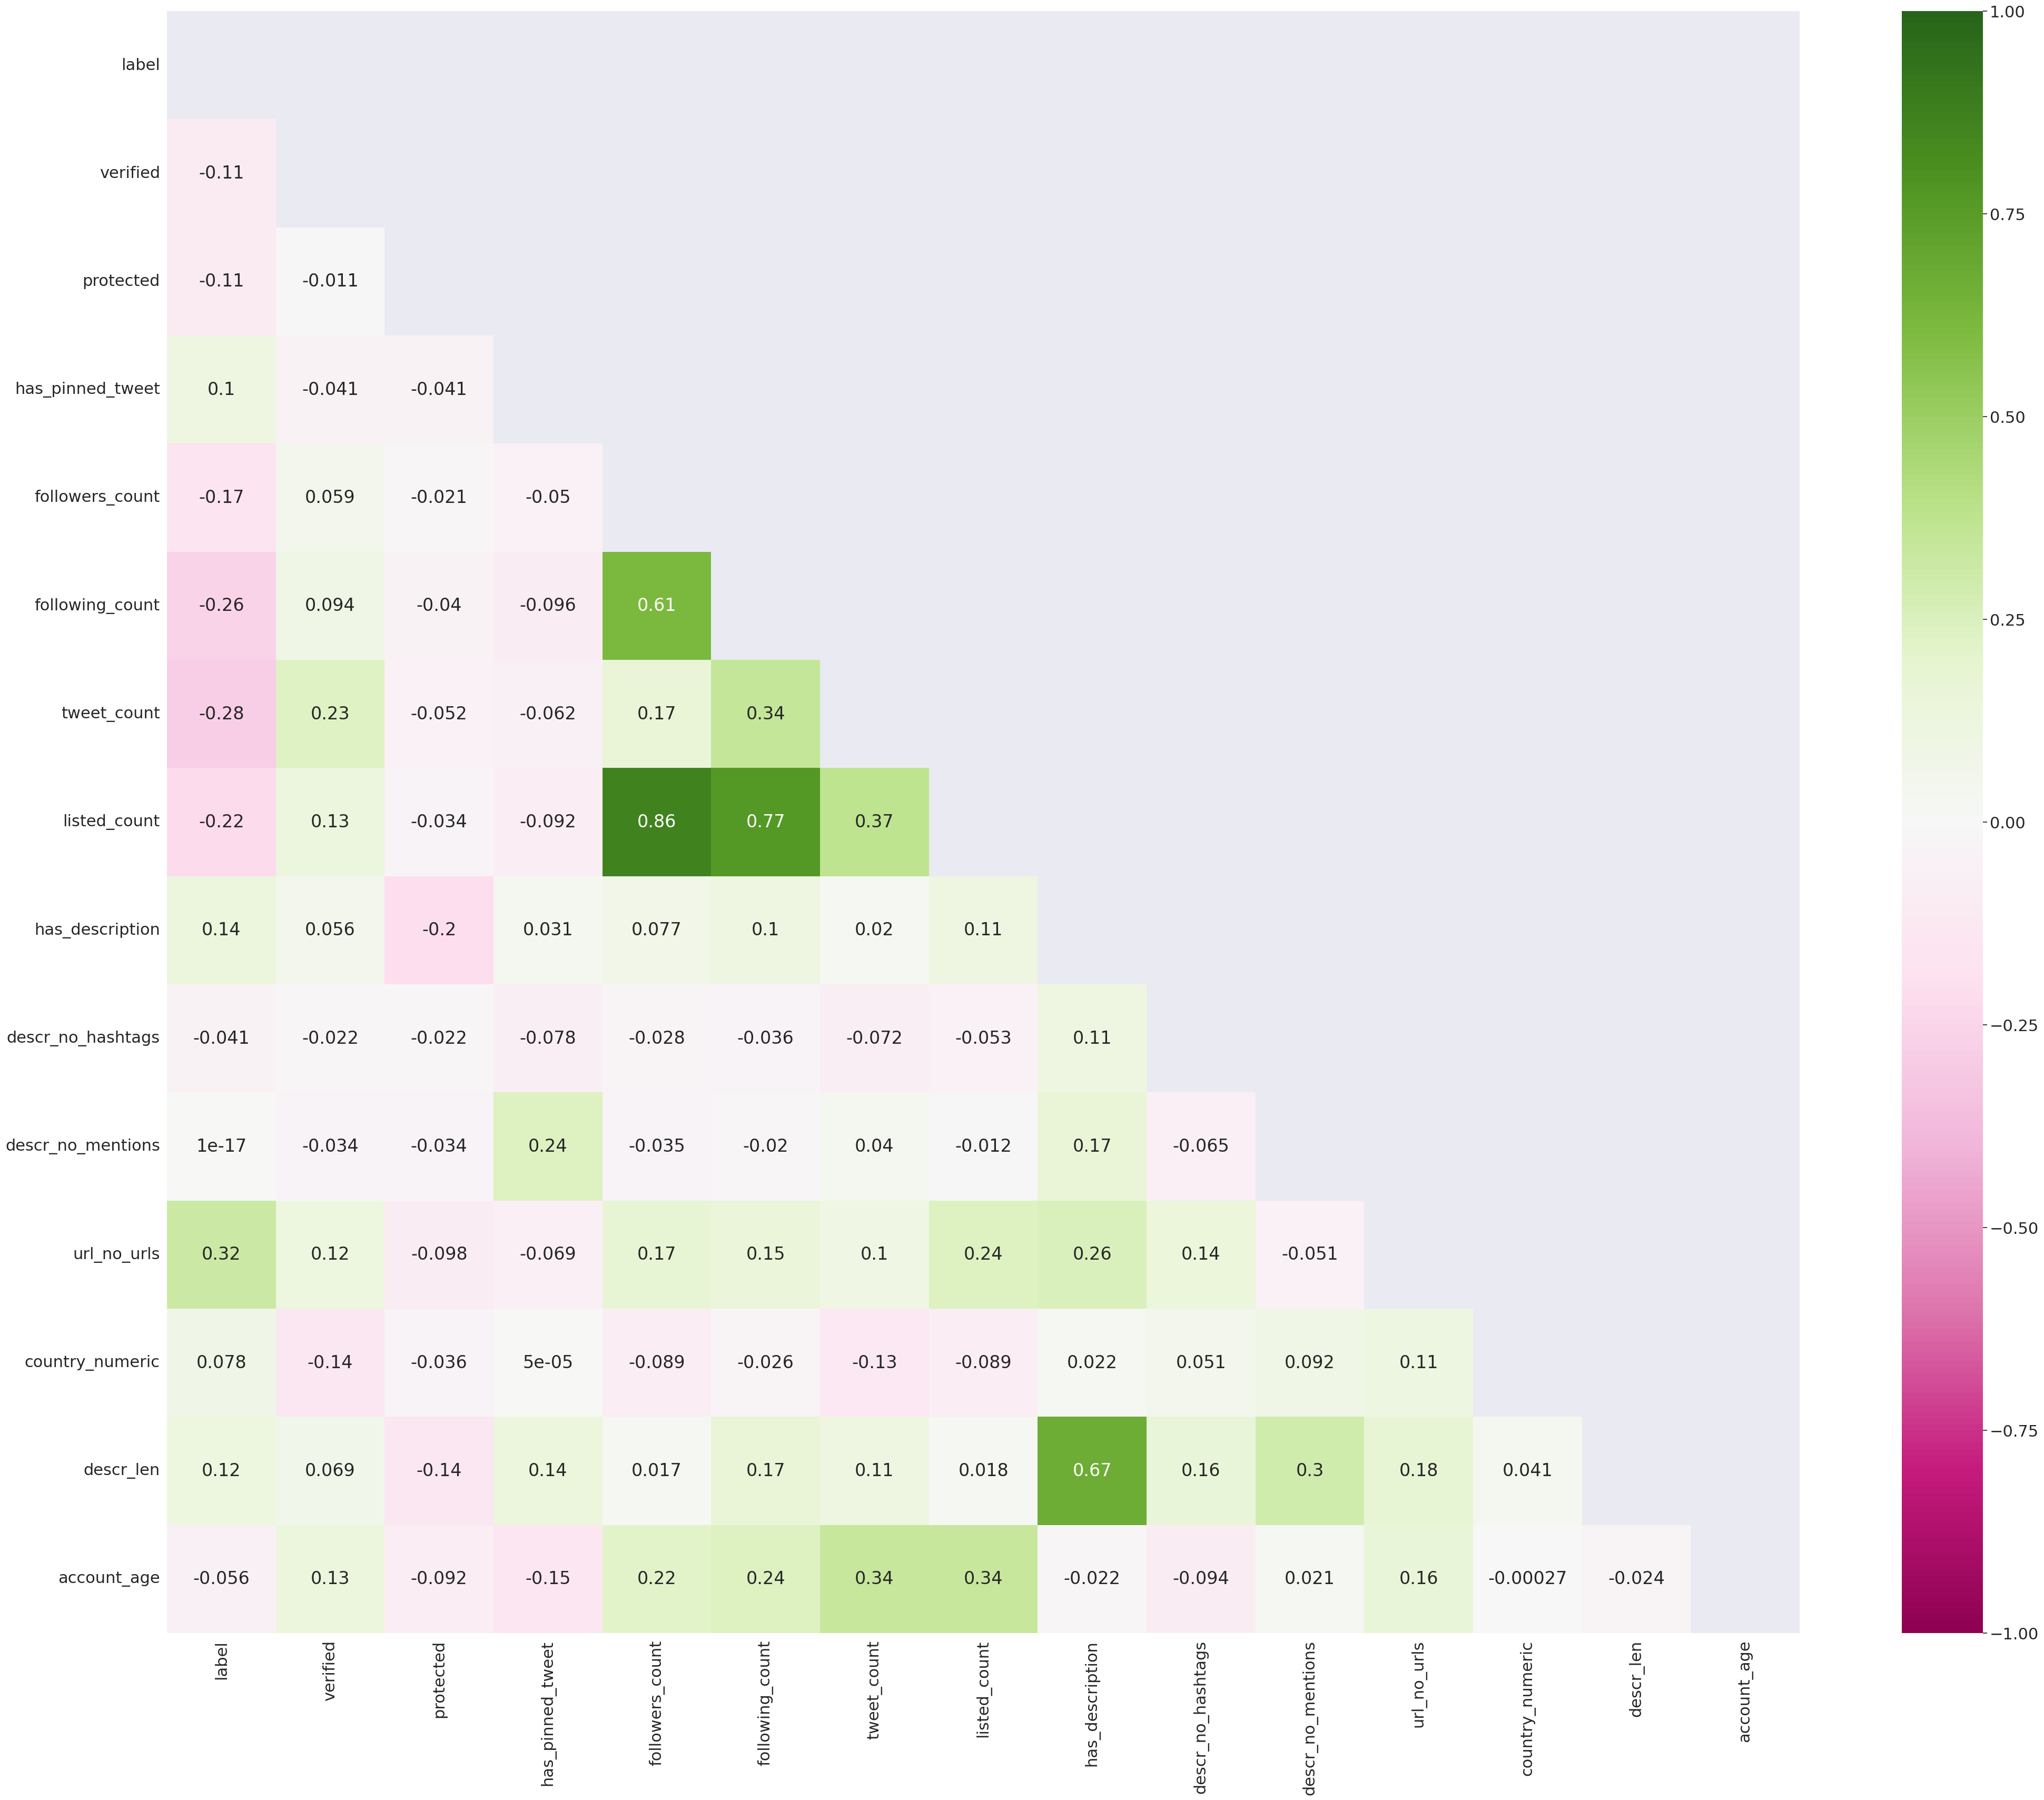

In [247]:
corr_threshold2 = 0.52
corr2 = train_data_wo_outliers.corr()
lower_tri2 = corr2.where(np.tril(np.ones(corr2.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri2, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr2 = []
for column in train_data_wo_outliers:
   for col in train_data_wo_outliers:
     if abs(lower_tri2[column][col]) > corr_threshold2:
         high_corr2.append((column, col, lower_tri2[column][col]))
high_corr2 = sorted(high_corr2, key=lambda x: x[2], reverse=True)

#### Drop column with higher correlation

In [248]:
f = plt.figure(figsize=(50, 40))
sns.set(font_scale=1)

<Figure size 5000x4000 with 0 Axes>

In [249]:
high_corr2

[('followers_count', 'listed_count', 0.8617735526436813),
 ('following_count', 'listed_count', 0.7731826438464142),
 ('has_description', 'descr_len', 0.6673842777063403),
 ('followers_count', 'following_count', 0.6097918256119753)]

In [250]:
train_data_wo_outliers = train_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)

#### Split data for input and output

In [251]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)


train_data_wo_outliers_X = train_data_wo_outliers.drop(['label'], axis=1)
train_data_wo_outliers_Y = pd.concat([train_data_wo_outliers['label']], axis=1)
val_data_wo_outliers_X = val_data_wo_outliers.drop(['label'], axis=1)
val_data_wo_outliers_Y = pd.concat([val_data_wo_outliers['label']], axis=1)
test_data_wo_outliers_X = test_data_wo_outliers.drop(['label'], axis=1)
test_data_wo_outliers_Y = pd.concat([test_data_wo_outliers['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [252]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [253]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [254]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [255]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [256]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [257]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

2023-08-22 21:28:31.526791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-22 21:28:31.539628: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-22 21:28:31.539704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2463f54bb7de): /proc/driver/nvidia/version does not exist
2023-08-22 21:28:31.787190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

### batch_size=10, epochs=200

#### Create and train model

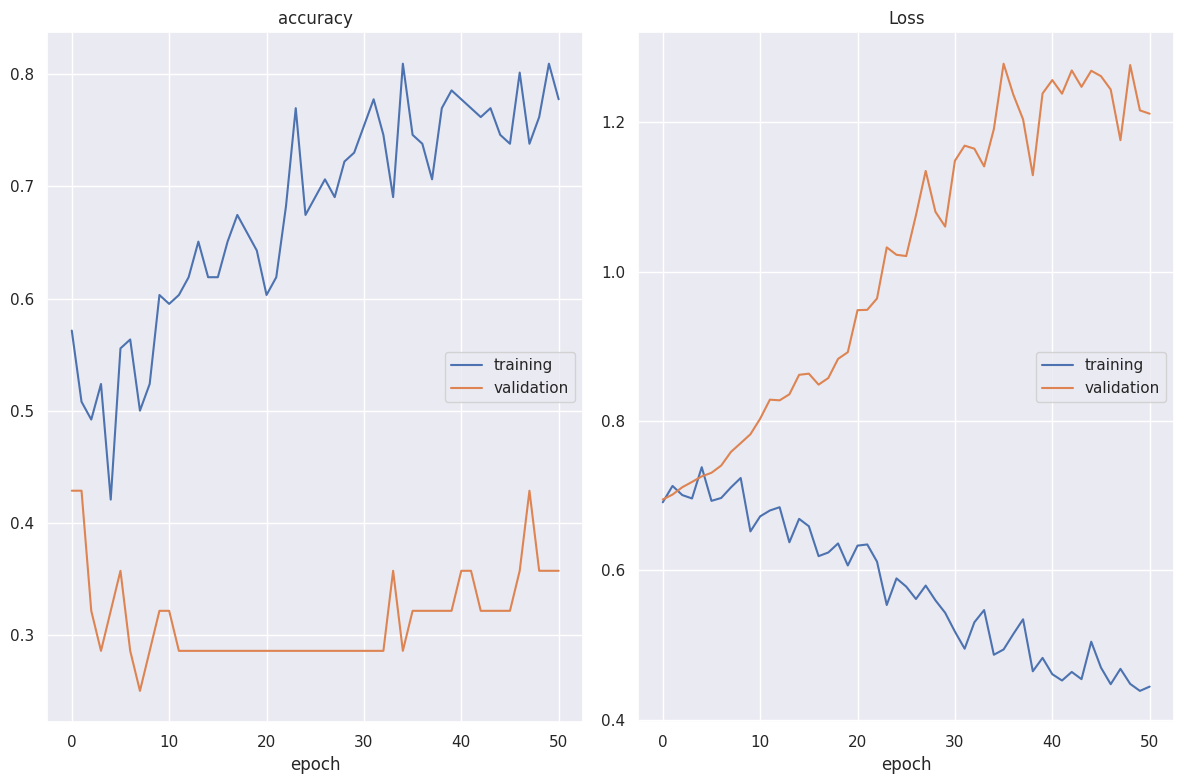

accuracy
	training         	 (min:    0.421, max:    0.810, cur:    0.778)
	validation       	 (min:    0.250, max:    0.429, cur:    0.357)
Loss
	training         	 (min:    0.438, max:    0.738, cur:    0.444)
	validation       	 (min:    0.695, max:    1.278, cur:    1.212)

Epoch 51: val_accuracy did not improve from 0.42857
13/13 [==============================] - 1s 48ms/step - loss: 0.4441 - accuracy: 0.7778 - val_loss: 1.2115 - val_accuracy: 0.3571


In [258]:
model_name = 'model_users_only_10000_1_v1_batch_size_10_epochs_200_with_location_mapped_to_country'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.4583333333333333
Precision: [0.4        0.47368421]
Recall: 0.75
F1 score: 0.580645
ROC AUC: 0.458333


(0.4583333333333333,
 array([0.4       , 0.47368421]),
 0.75,
 0.5806451612903226,
 0.4583333333333333)

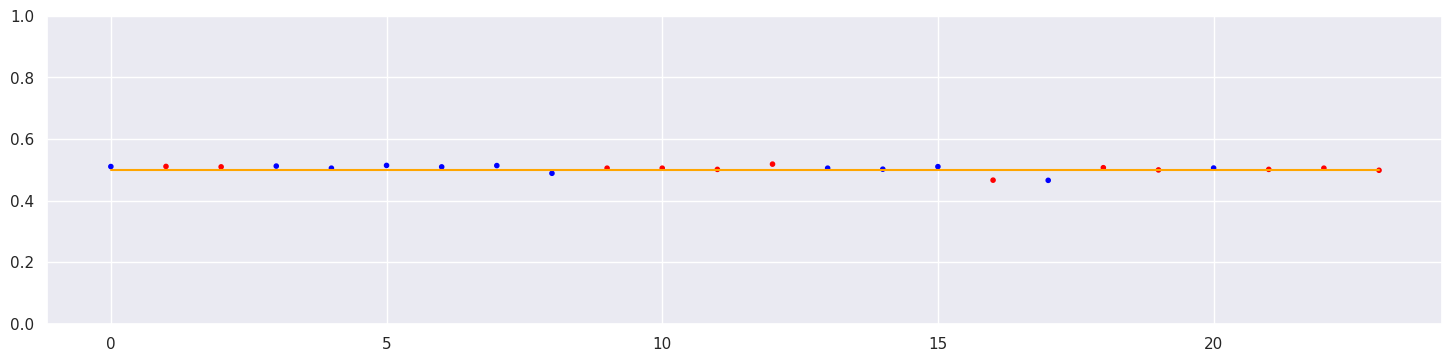

<Figure size 640x480 with 0 Axes>

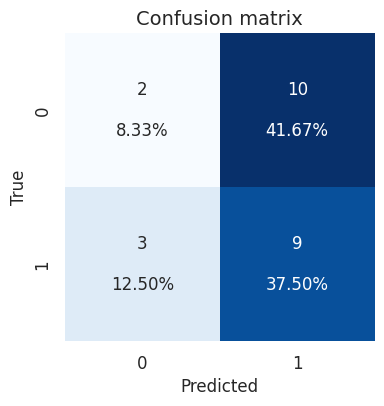

In [259]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=50, epochs=200

In [260]:
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model1_v1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                480       
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

### Train model

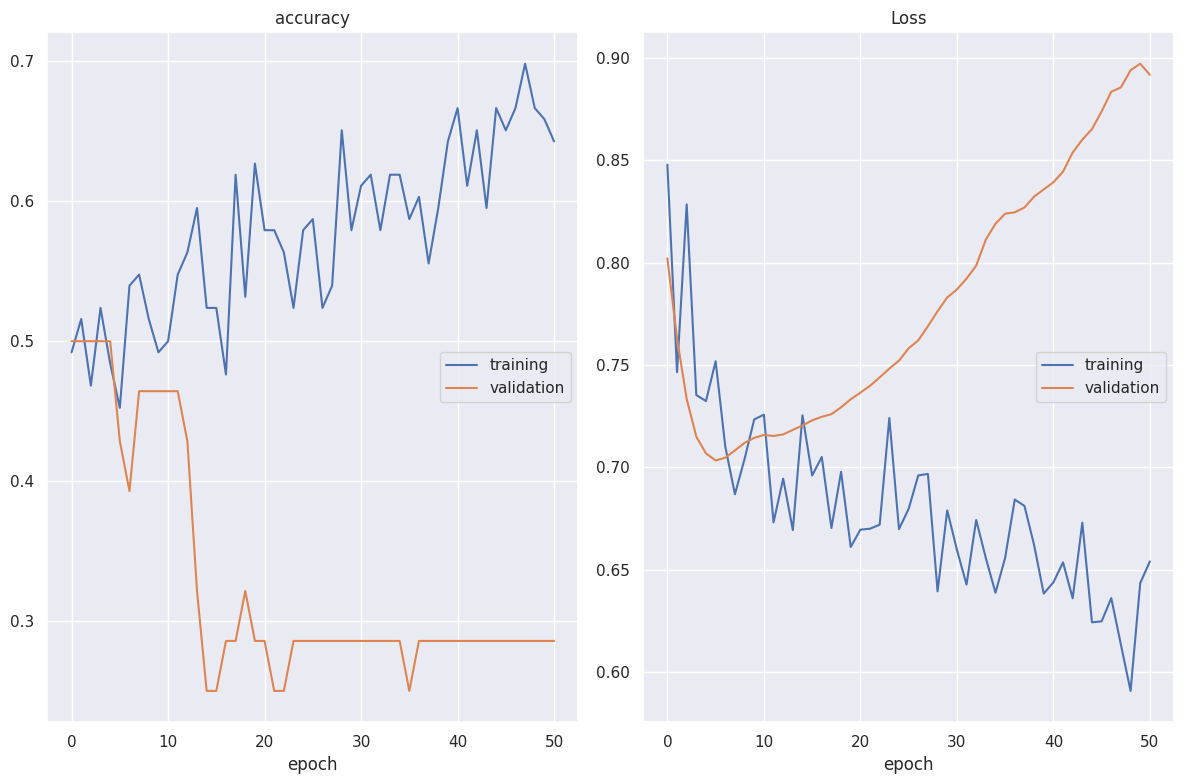

accuracy
	training         	 (min:    0.452, max:    0.698, cur:    0.643)
	validation       	 (min:    0.250, max:    0.500, cur:    0.286)
Loss
	training         	 (min:    0.591, max:    0.848, cur:    0.654)
	validation       	 (min:    0.703, max:    0.897, cur:    0.892)

Epoch 51: val_accuracy did not improve from 0.50000
3/3 [==============================] - 1s 281ms/step - loss: 0.6542 - accuracy: 0.6429 - val_loss: 0.8916 - val_accuracy: 0.2857


In [ ]:
model_name = 'model_users_only_10000_1_v1_batch_size_50_epochs_200_with_location_mapped_to_country'
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=200)

In [ ]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

#### Prediction

In [ ]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

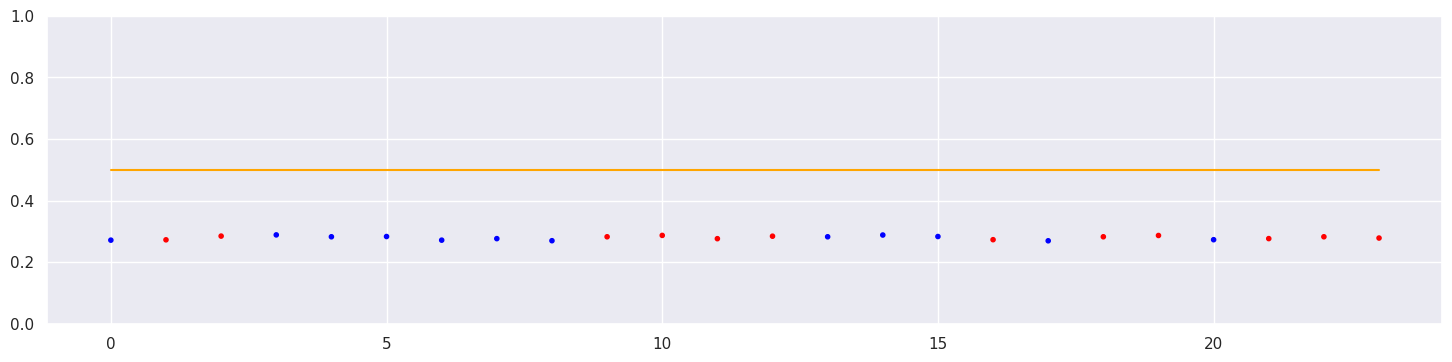

In [ ]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.5
Precision: [0.5 0. ]
Recall: 0.0
F1 score: 0.000000
ROC AUC: 0.500000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



(0.5, array([0.5, 0. ]), 0.0, 0.0, 0.5)

<Figure size 640x480 with 0 Axes>

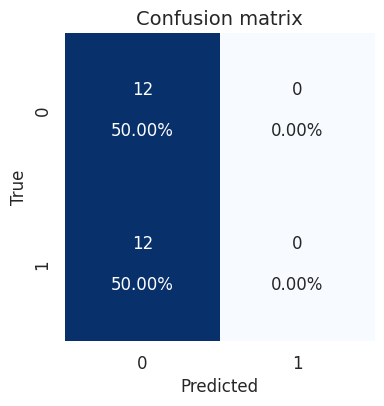

In [ ]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=100, epochs=200

#### Create and train model

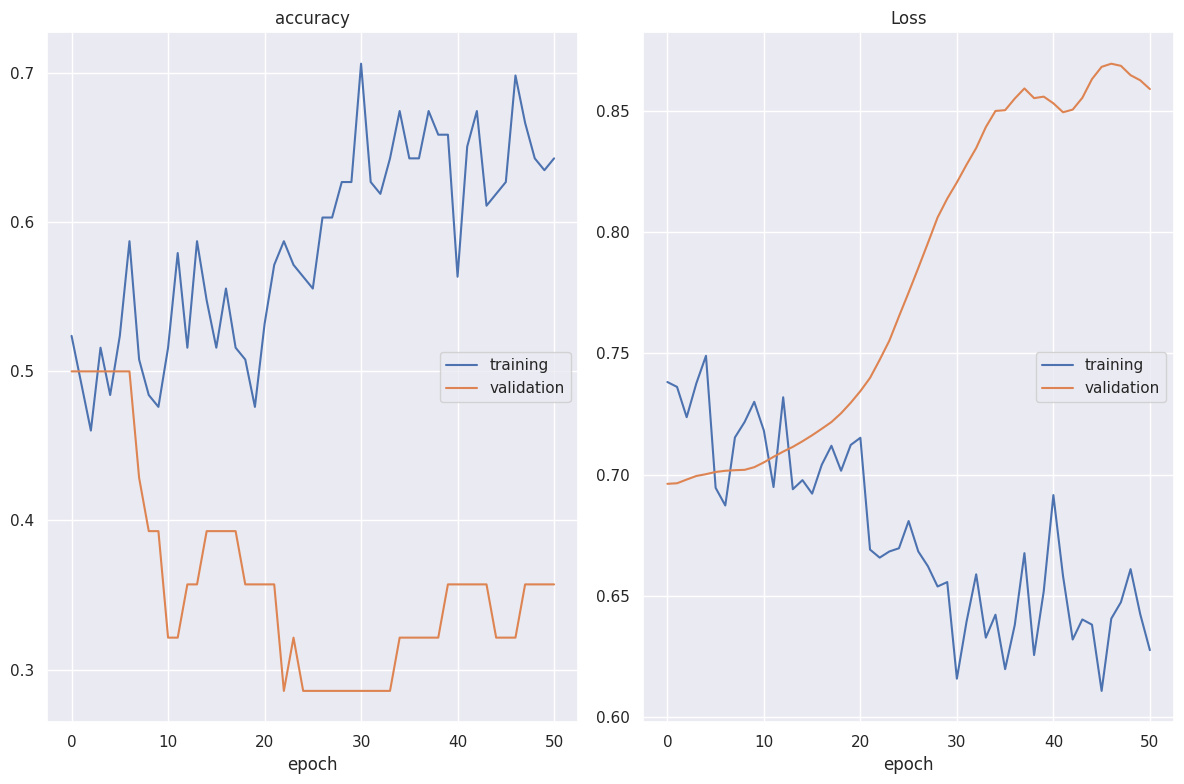

accuracy
	training         	 (min:    0.460, max:    0.706, cur:    0.643)
	validation       	 (min:    0.286, max:    0.500, cur:    0.357)
Loss
	training         	 (min:    0.611, max:    0.749, cur:    0.628)
	validation       	 (min:    0.696, max:    0.869, cur:    0.859)

Epoch 51: val_accuracy did not improve from 0.50000
2/2 [==============================] - 1s 567ms/step - loss: 0.6277 - accuracy: 0.6429 - val_loss: 0.8590 - val_accuracy: 0.3571


In [266]:
model_name = 'model_users_only_10000_1_v1_batch_size_100_epochs_200_with_location_mapped_to_country'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.5
Precision: [0.  0.5]
Recall: 1.0
F1 score: 0.666667
ROC AUC: 0.500000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



(0.5, array([0. , 0.5]), 1.0, 0.6666666666666666, 0.5)

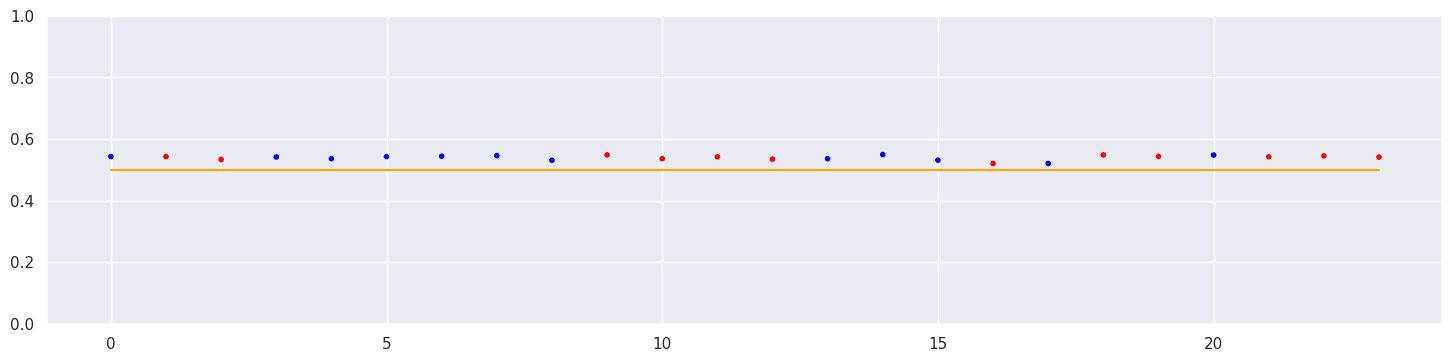

<Figure size 640x480 with 0 Axes>

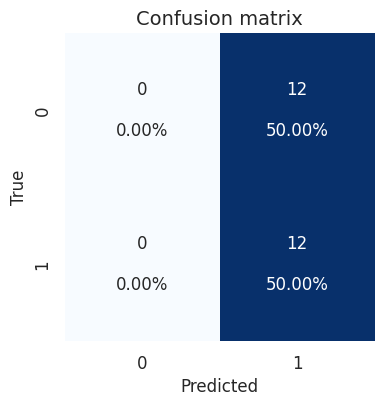

In [267]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=150, epochs=200

#### Create and train model

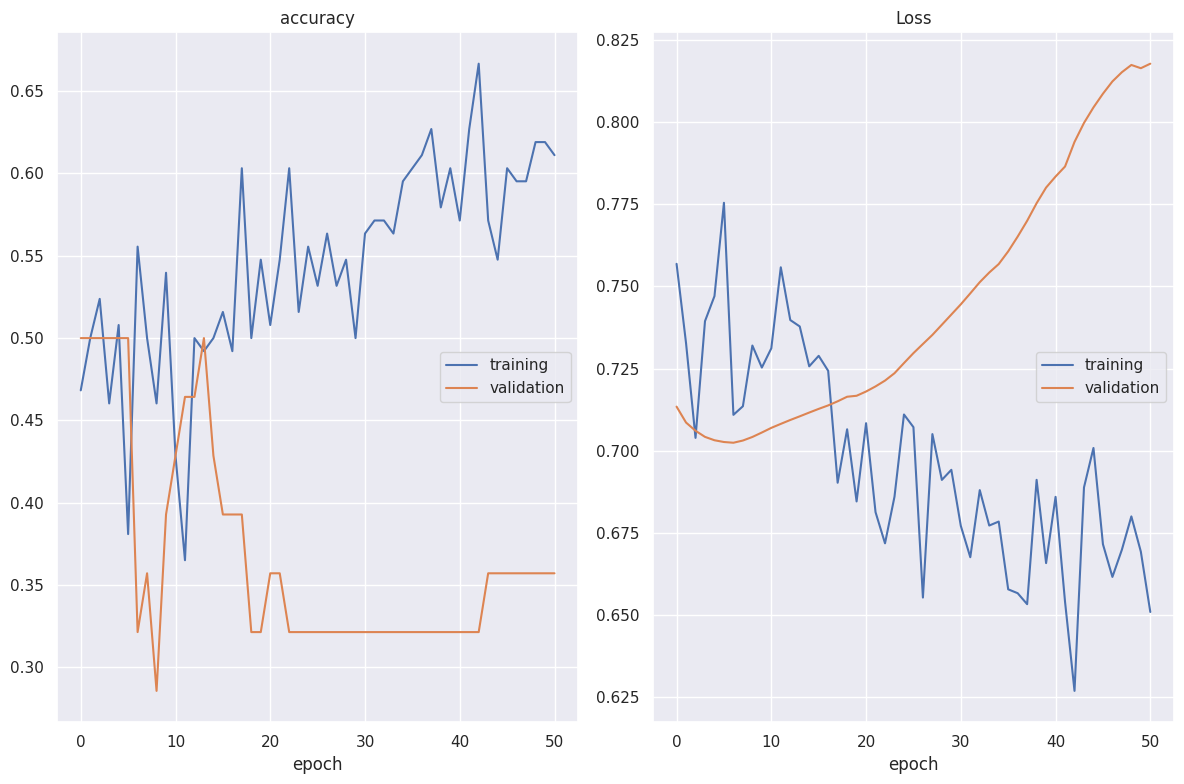

accuracy
	training         	 (min:    0.365, max:    0.667, cur:    0.611)
	validation       	 (min:    0.286, max:    0.500, cur:    0.357)
Loss
	training         	 (min:    0.627, max:    0.775, cur:    0.651)
	validation       	 (min:    0.702, max:    0.818, cur:    0.818)

Epoch 51: val_accuracy did not improve from 0.50000
1/1 [==============================] - 1s 600ms/step - loss: 0.6510 - accuracy: 0.6111 - val_loss: 0.8177 - val_accuracy: 0.3571


In [268]:
model_name = 'model_users_only_10000_1_v1_batch_size_150_epochs_200_with_location_mapped_to_country'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=150, epochs=200)

#### Prediction and results

Accuracy: 0.5
Precision: [0.5 0. ]
Recall: 0.0
F1 score: 0.000000
ROC AUC: 0.500000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



(0.5, array([0.5, 0. ]), 0.0, 0.0, 0.5)

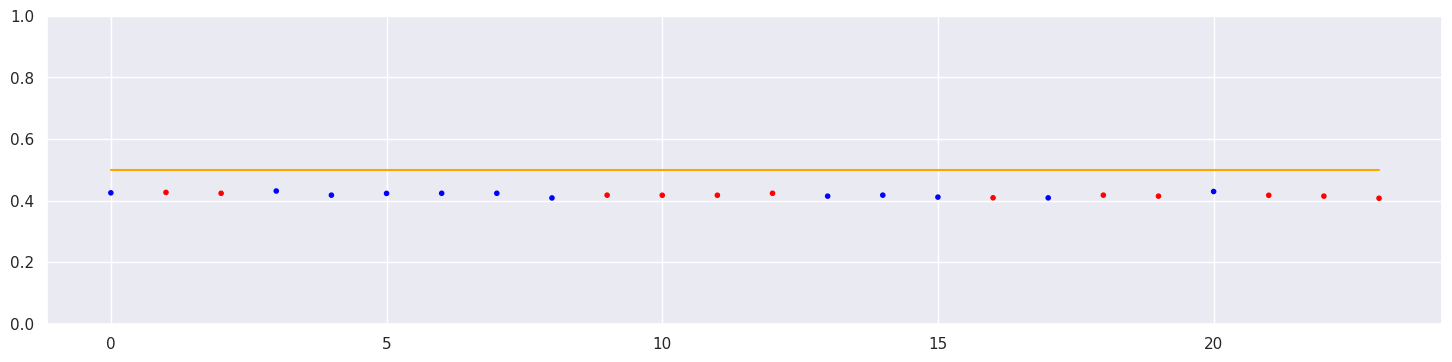

<Figure size 640x480 with 0 Axes>

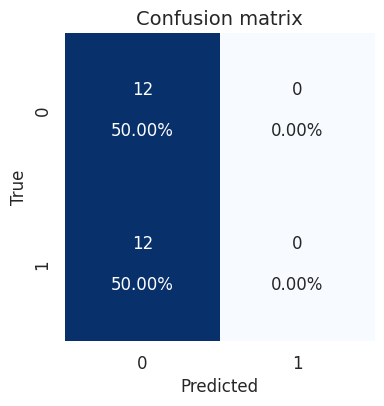

In [269]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=200, epochs=200

#### Create and train model

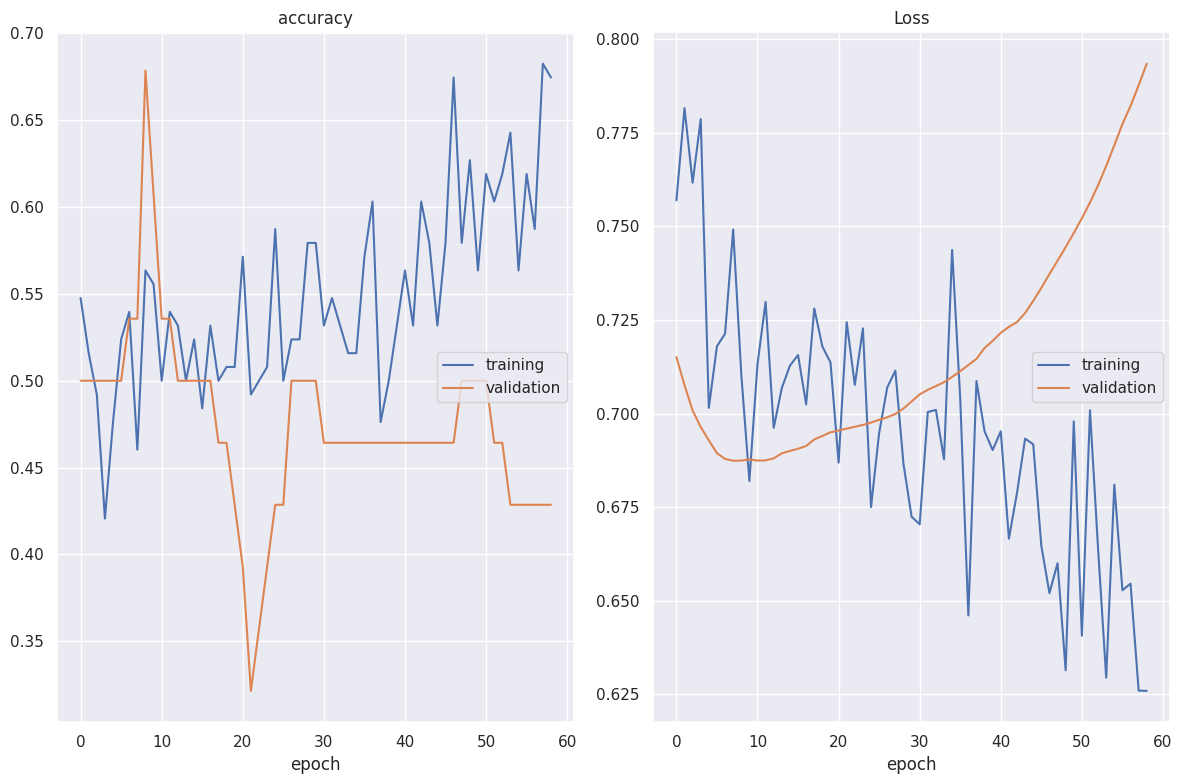

accuracy
	training         	 (min:    0.421, max:    0.683, cur:    0.675)
	validation       	 (min:    0.321, max:    0.679, cur:    0.429)
Loss
	training         	 (min:    0.626, max:    0.782, cur:    0.626)
	validation       	 (min:    0.687, max:    0.793, cur:    0.793)

Epoch 59: val_accuracy did not improve from 0.67857
1/1 [==============================] - 1s 594ms/step - loss: 0.6259 - accuracy: 0.6746 - val_loss: 0.7934 - val_accuracy: 0.4286


In [270]:
model_name = 'model_users_only_10000_1_v1_batch_size_200_epochs_200_with_location_mapped_to_country'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=200, epochs=200)

#### Prediction and results

Accuracy: 0.5416666666666666
Precision: [0.54545455 0.53846154]
Recall: 0.5833333333333334
F1 score: 0.560000
ROC AUC: 0.541667


(0.5416666666666666,
 array([0.54545455, 0.53846154]),
 0.5833333333333334,
 0.5599999999999999,
 0.5416666666666667)

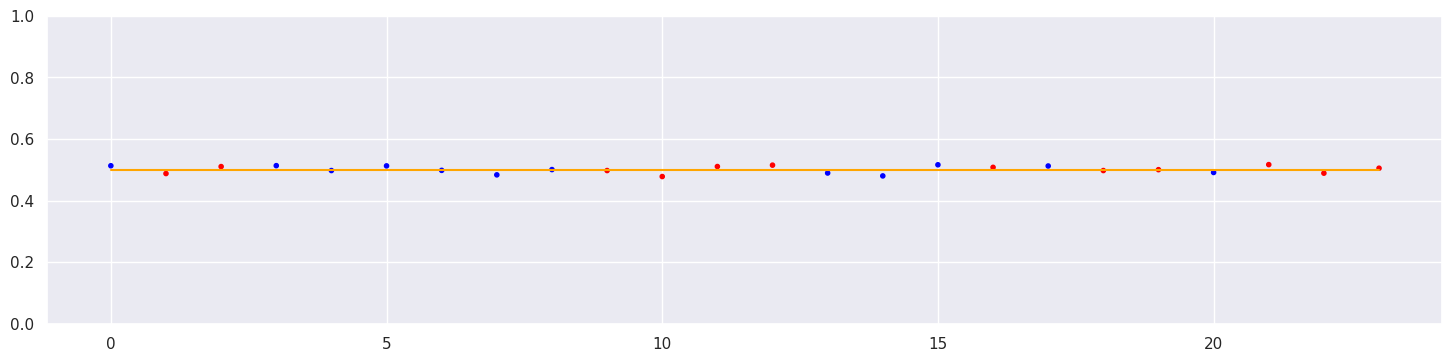

<Figure size 640x480 with 0 Axes>

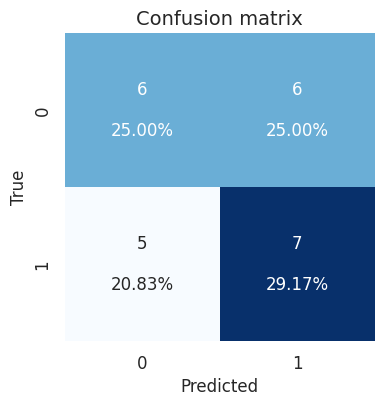

In [271]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=250, epochs=200

#### Create and train model

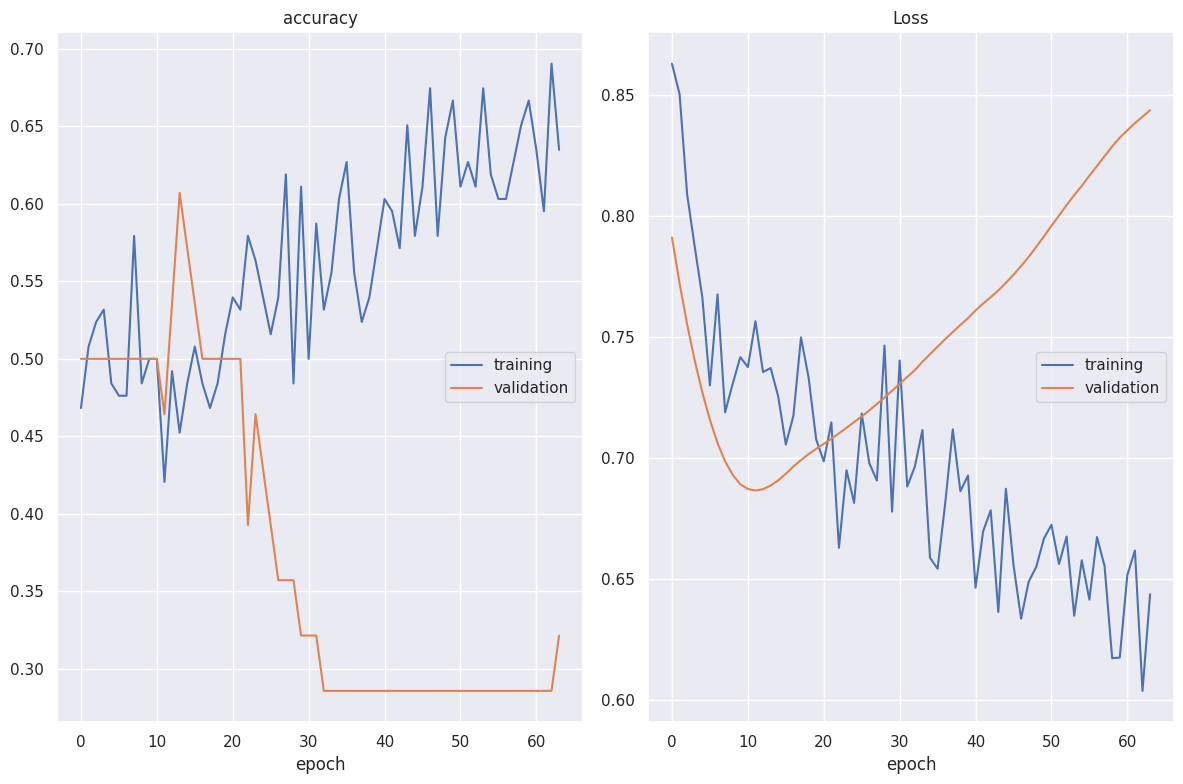

accuracy
	training         	 (min:    0.421, max:    0.690, cur:    0.635)
	validation       	 (min:    0.286, max:    0.607, cur:    0.321)
Loss
	training         	 (min:    0.604, max:    0.863, cur:    0.644)
	validation       	 (min:    0.687, max:    0.844, cur:    0.844)

Epoch 64: val_accuracy did not improve from 0.60714
1/1 [==============================] - 1s 595ms/step - loss: 0.6438 - accuracy: 0.6349 - val_loss: 0.8439 - val_accuracy: 0.3214


In [272]:
model_name = 'model_users_only_10000_1_v1_batch_size_250_epochs_200_with_location_mapped_to_country'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=250, epochs=200)

#### Prediction and results

Accuracy: 0.4166666666666667
Precision: [0.42857143 0.4       ]
Recall: 0.3333333333333333
F1 score: 0.363636
ROC AUC: 0.416667


(0.4166666666666667,
 array([0.42857143, 0.4       ]),
 0.3333333333333333,
 0.3636363636363636,
 0.41666666666666663)

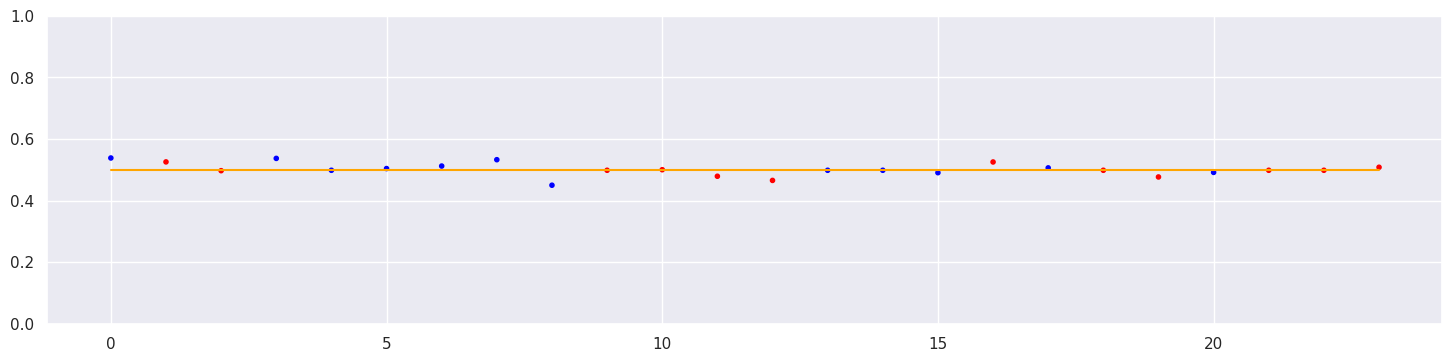

<Figure size 640x480 with 0 Axes>

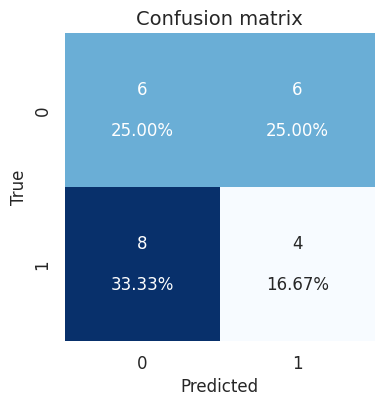

In [273]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### Model 1. - version for data reduced by outliers

### batch_size=10, epochs=200

#### Create and train model

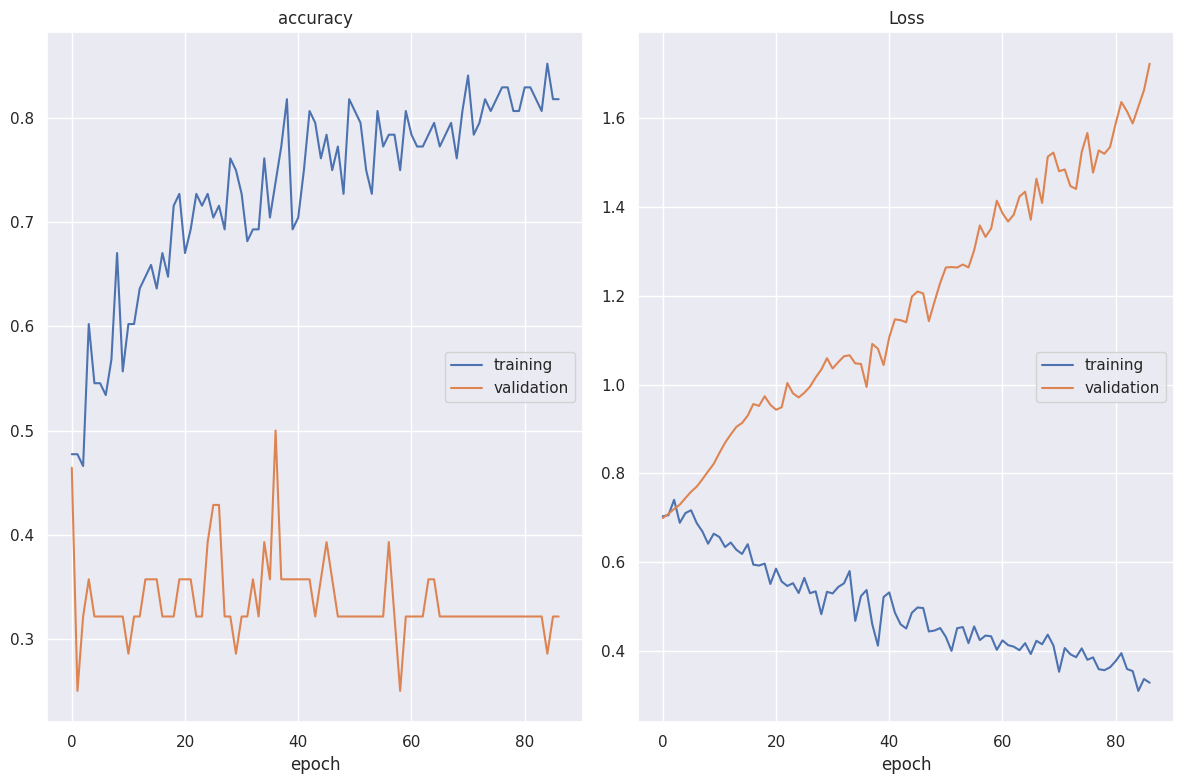

accuracy
	training         	 (min:    0.466, max:    0.852, cur:    0.818)
	validation       	 (min:    0.250, max:    0.500, cur:    0.321)
Loss
	training         	 (min:    0.309, max:    0.740, cur:    0.328)
	validation       	 (min:    0.699, max:    1.723, cur:    1.723)

Epoch 87: val_accuracy did not improve from 0.50000
9/9 [==============================] - 1s 69ms/step - loss: 0.3278 - accuracy: 0.8182 - val_loss: 1.7233 - val_accuracy: 0.3214


In [274]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_10_epochs_200_with_location_mapped_to_country'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.7083333333333334
Precision: [0.63157895 1.        ]
Recall: 0.4166666666666667
F1 score: 0.588235
ROC AUC: 0.708333


(0.7083333333333334,
 array([0.63157895, 1.        ]),
 0.4166666666666667,
 0.5882352941176471,
 0.7083333333333334)

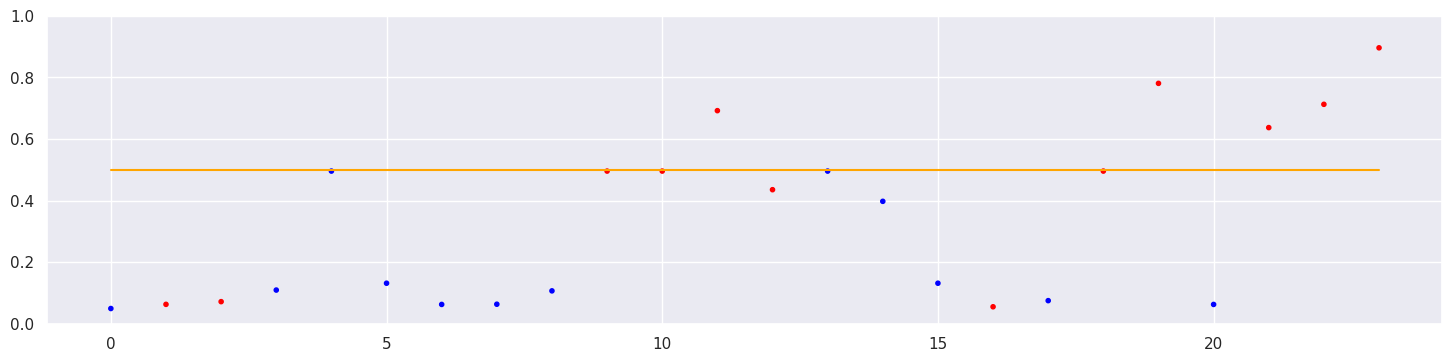

<Figure size 640x480 with 0 Axes>

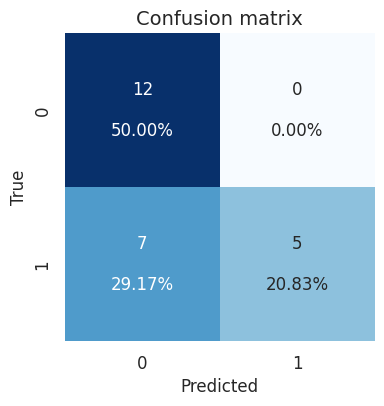

In [275]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=50, epochs=200

#### Create and train model

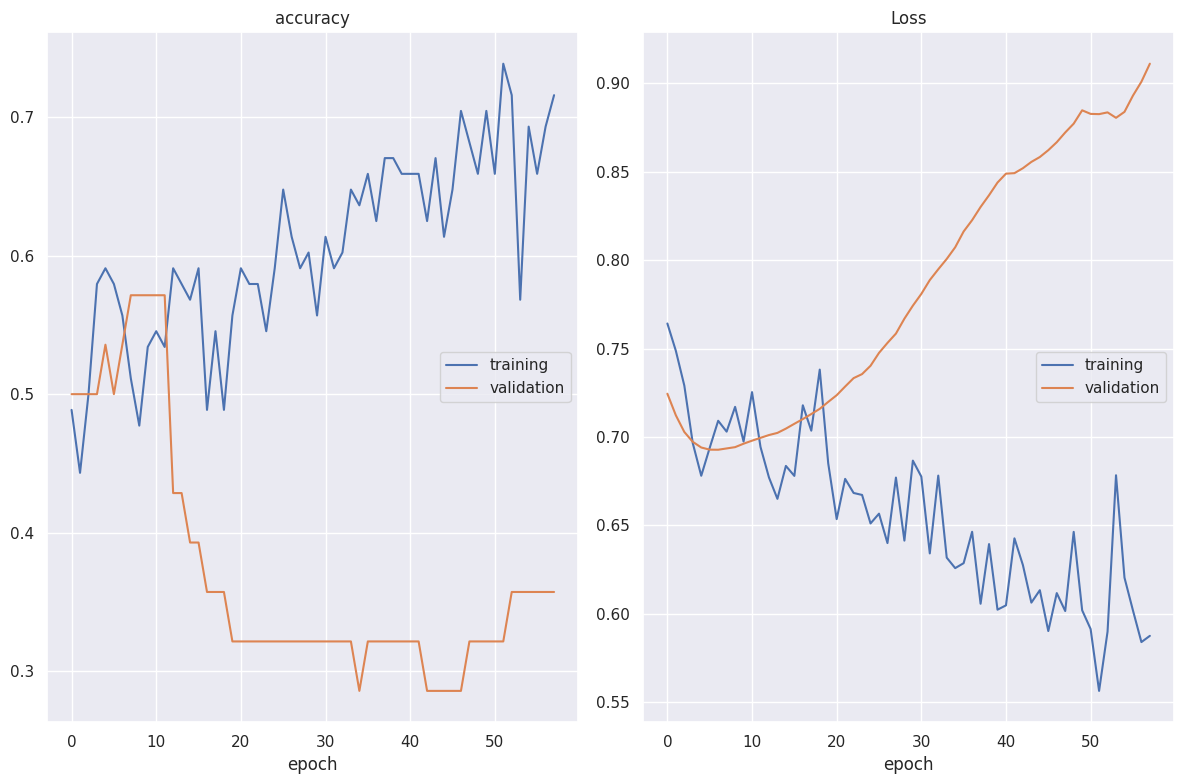

accuracy
	training         	 (min:    0.443, max:    0.739, cur:    0.716)
	validation       	 (min:    0.286, max:    0.571, cur:    0.357)
Loss
	training         	 (min:    0.556, max:    0.764, cur:    0.588)
	validation       	 (min:    0.693, max:    0.911, cur:    0.911)

Epoch 58: val_accuracy did not improve from 0.57143
2/2 [==============================] - 1s 555ms/step - loss: 0.5875 - accuracy: 0.7159 - val_loss: 0.9110 - val_accuracy: 0.3571


In [276]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_50_epochs_200_with_location_mapped_to_country'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=50, epochs=200)

#### Prediction and results

Accuracy: 0.375
Precision: [0.41176471 0.28571429]
Recall: 0.16666666666666666
F1 score: 0.210526
ROC AUC: 0.375000


(0.375,
 array([0.41176471, 0.28571429]),
 0.16666666666666666,
 0.2105263157894737,
 0.37499999999999994)

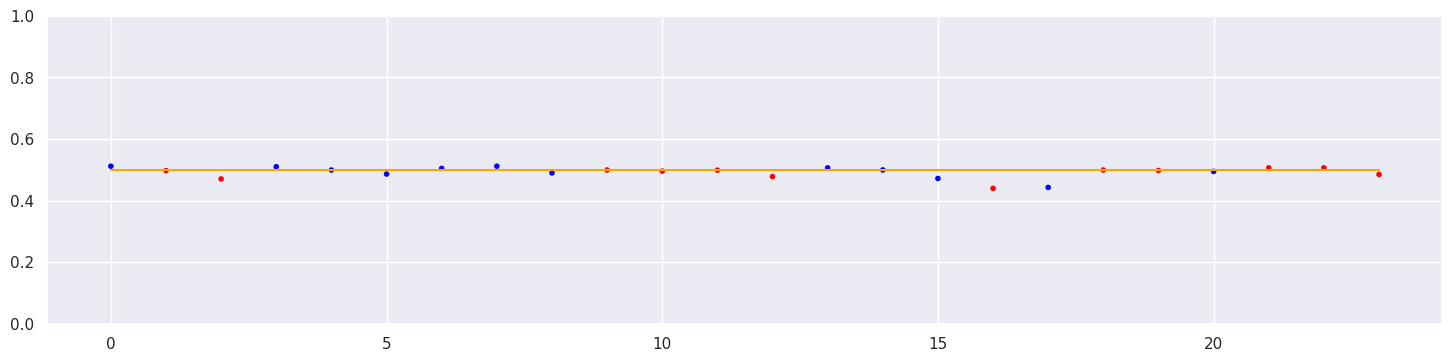

<Figure size 640x480 with 0 Axes>

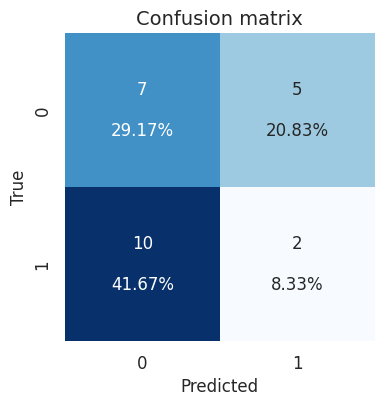

In [277]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=100, epochs=200

#### Create and train model

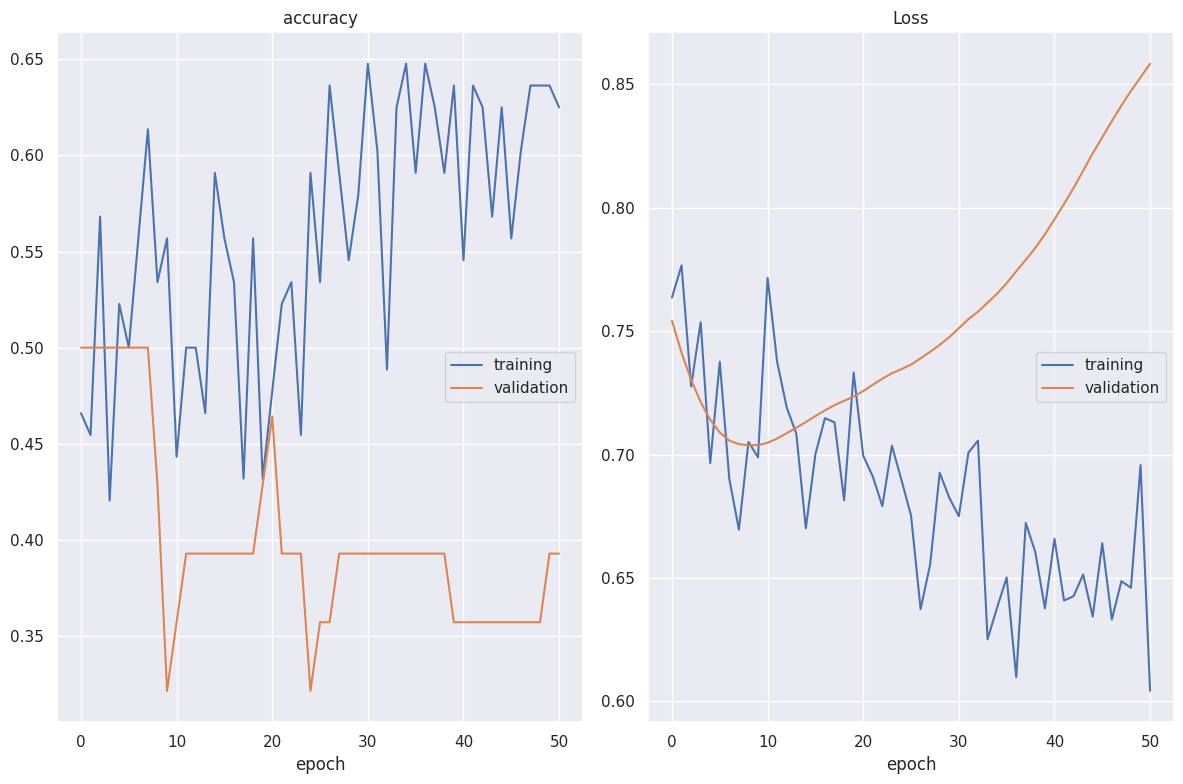

accuracy
	training         	 (min:    0.420, max:    0.648, cur:    0.625)
	validation       	 (min:    0.321, max:    0.500, cur:    0.393)
Loss
	training         	 (min:    0.604, max:    0.777, cur:    0.604)
	validation       	 (min:    0.704, max:    0.858, cur:    0.858)

Epoch 51: val_accuracy did not improve from 0.50000
1/1 [==============================] - 1s 563ms/step - loss: 0.6043 - accuracy: 0.6250 - val_loss: 0.8583 - val_accuracy: 0.3929


In [278]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_100_epochs_200_with_location_mapped_to_country'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.5
Precision: [0.  0.5]
Recall: 1.0
F1 score: 0.666667
ROC AUC: 0.500000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



(0.5, array([0. , 0.5]), 1.0, 0.6666666666666666, 0.5)

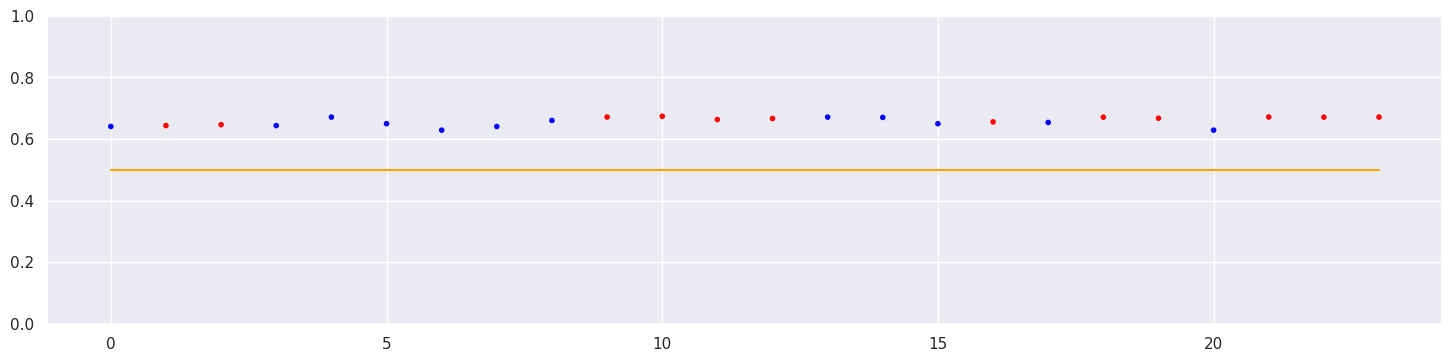

<Figure size 640x480 with 0 Axes>

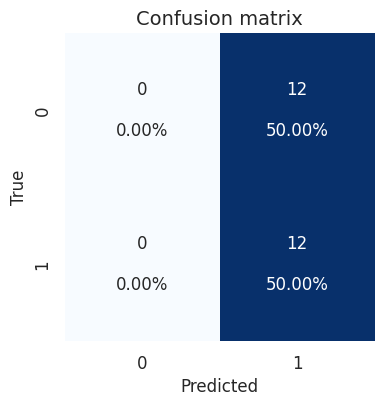

In [279]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=150, epochs=200

#### Create and train model

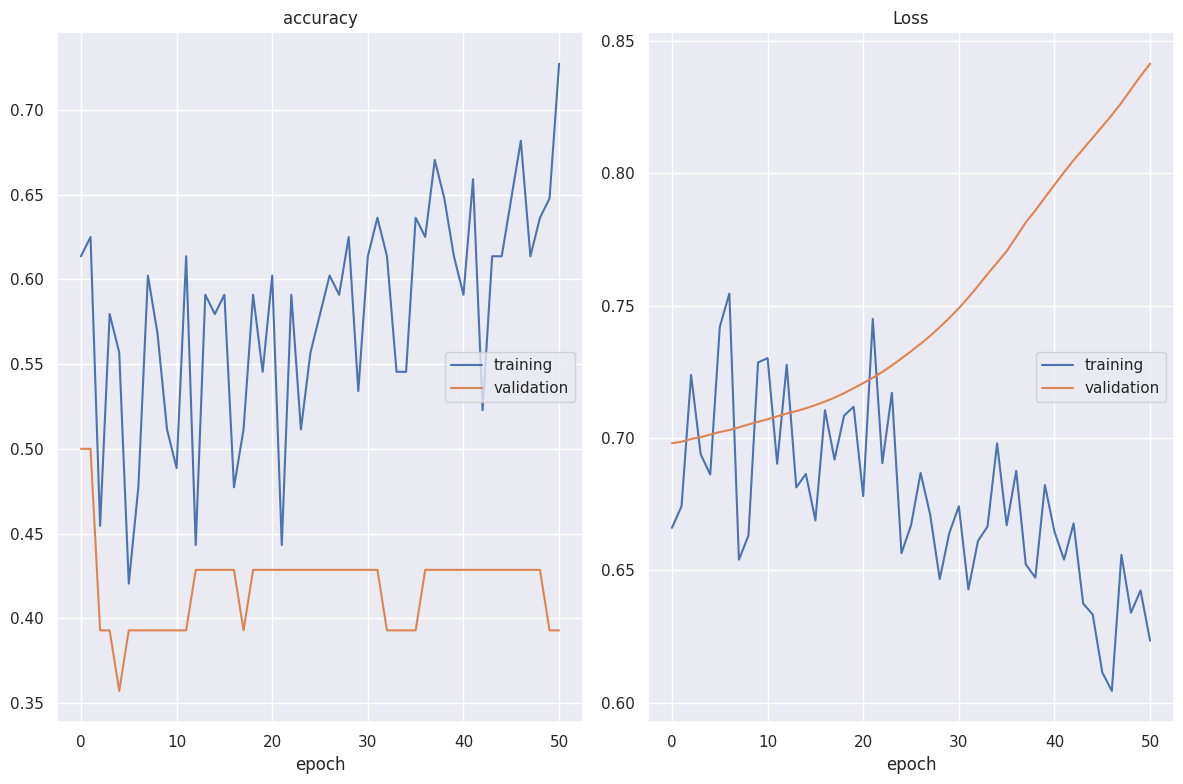

accuracy
	training         	 (min:    0.420, max:    0.727, cur:    0.727)
	validation       	 (min:    0.357, max:    0.500, cur:    0.393)
Loss
	training         	 (min:    0.604, max:    0.755, cur:    0.623)
	validation       	 (min:    0.698, max:    0.841, cur:    0.841)

Epoch 51: val_accuracy did not improve from 0.50000
1/1 [==============================] - 1s 581ms/step - loss: 0.6234 - accuracy: 0.7273 - val_loss: 0.8415 - val_accuracy: 0.3929


In [280]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_150_epochs_200_with_location_mapped_to_country'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=150, epochs=200)

#### Prediction and results

Accuracy: 0.5
Precision: [0.5 0. ]
Recall: 0.0
F1 score: 0.000000
ROC AUC: 0.500000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



(0.5, array([0.5, 0. ]), 0.0, 0.0, 0.5)

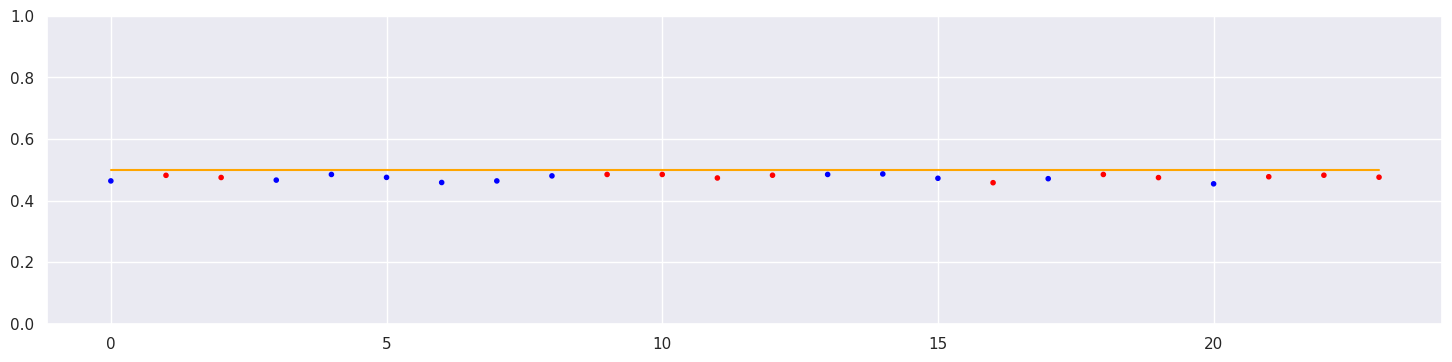

<Figure size 640x480 with 0 Axes>

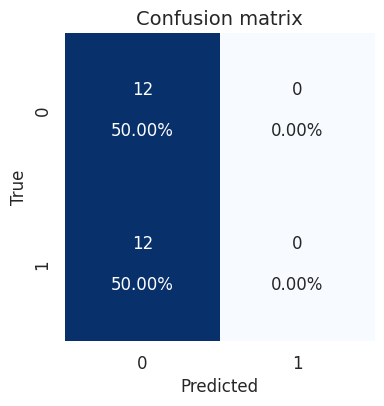

In [281]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=200, epochs=200

#### Create and train model

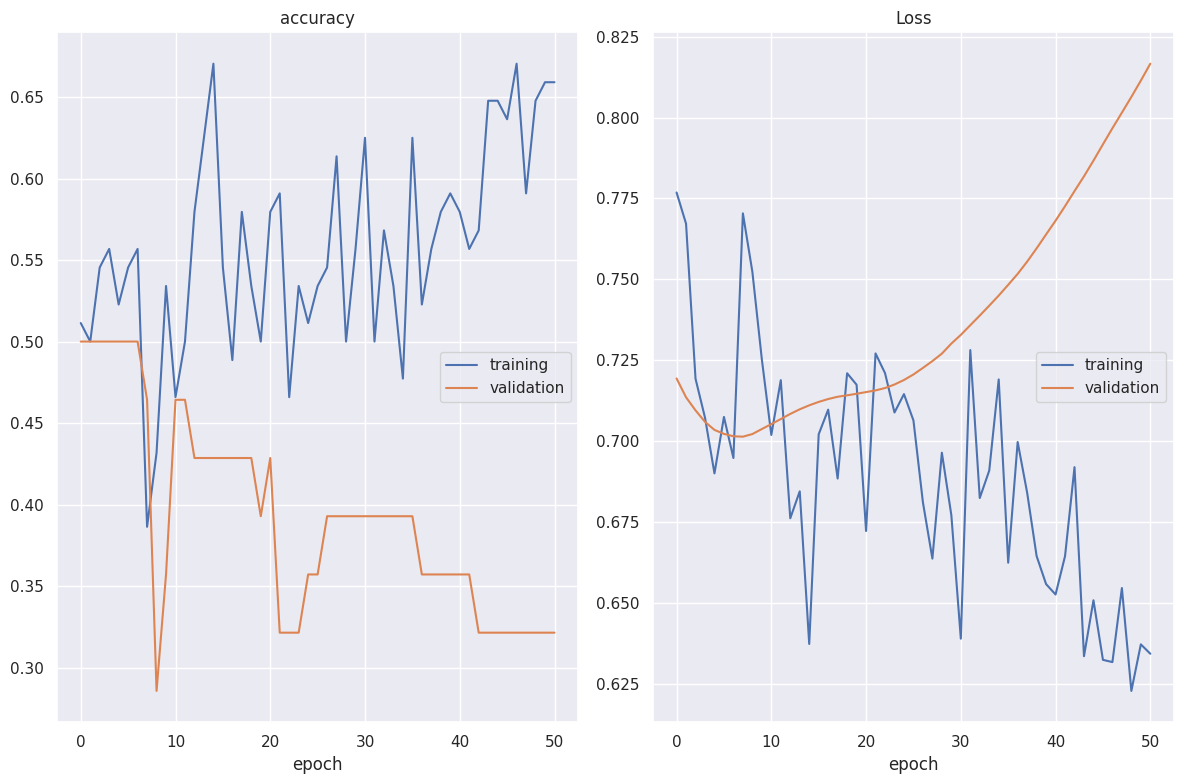

accuracy
	training         	 (min:    0.386, max:    0.670, cur:    0.659)
	validation       	 (min:    0.286, max:    0.500, cur:    0.321)
Loss
	training         	 (min:    0.623, max:    0.777, cur:    0.634)
	validation       	 (min:    0.701, max:    0.817, cur:    0.817)

Epoch 51: val_accuracy did not improve from 0.50000
1/1 [==============================] - 1s 581ms/step - loss: 0.6344 - accuracy: 0.6591 - val_loss: 0.8166 - val_accuracy: 0.3214


In [282]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_200_epochs_200_with_location_mapped_to_country'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=200, epochs=200)

#### Prediction and results

Accuracy: 0.5
Precision: [0.5 0. ]
Recall: 0.0
F1 score: 0.000000
ROC AUC: 0.500000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



(0.5, array([0.5, 0. ]), 0.0, 0.0, 0.5)

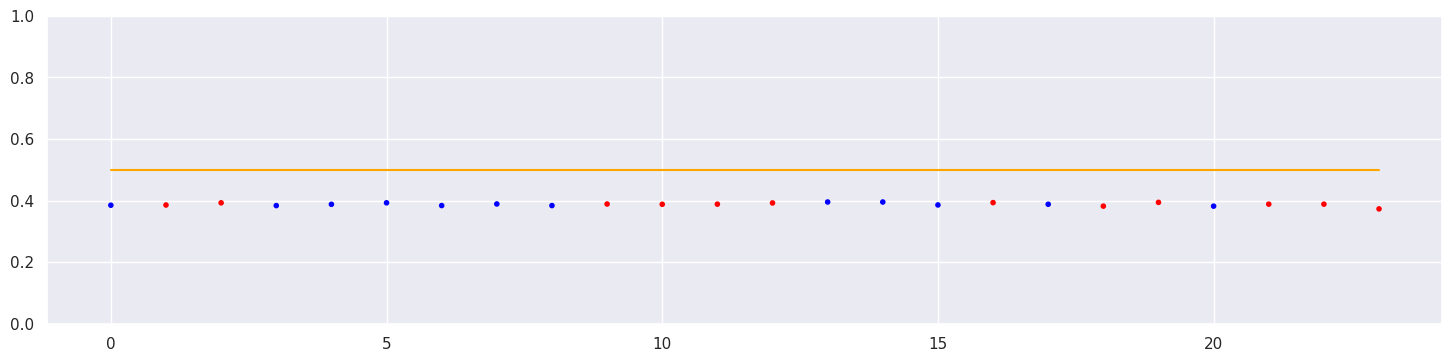

<Figure size 640x480 with 0 Axes>

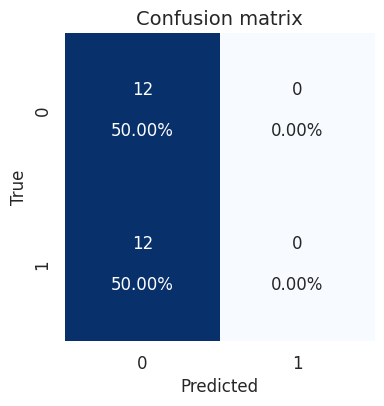

In [283]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=250, epochs=200

#### Create and train model

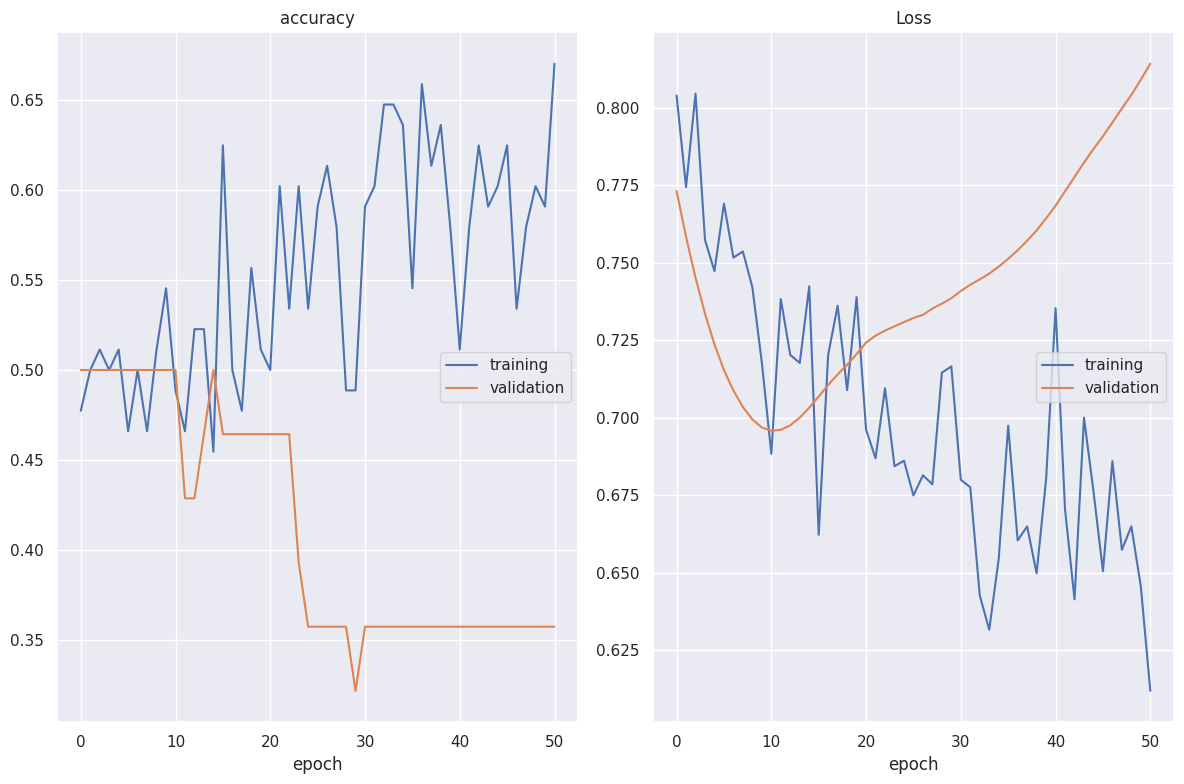

accuracy
	training         	 (min:    0.455, max:    0.670, cur:    0.670)
	validation       	 (min:    0.321, max:    0.500, cur:    0.357)
Loss
	training         	 (min:    0.612, max:    0.805, cur:    0.612)
	validation       	 (min:    0.696, max:    0.814, cur:    0.814)

Epoch 51: val_accuracy did not improve from 0.50000
1/1 [==============================] - 1s 578ms/step - loss: 0.6118 - accuracy: 0.6705 - val_loss: 0.8142 - val_accuracy: 0.3571


In [284]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_250_epochs_200_with_location_mapped_to_country'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=250, epochs=200)

#### Prediction and results

Accuracy: 0.5
Precision: [0.5 0. ]
Recall: 0.0
F1 score: 0.000000
ROC AUC: 0.500000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



(0.5, array([0.5, 0. ]), 0.0, 0.0, 0.5)

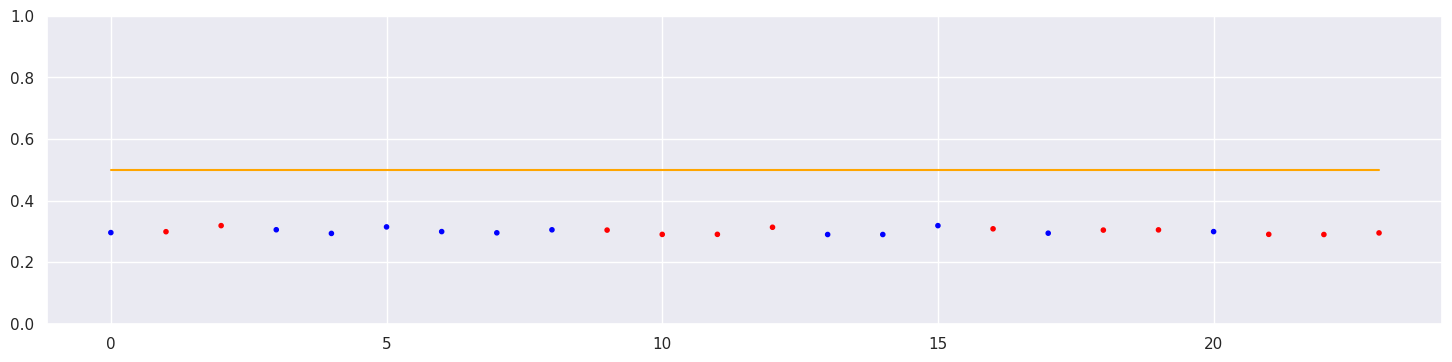

<Figure size 640x480 with 0 Axes>

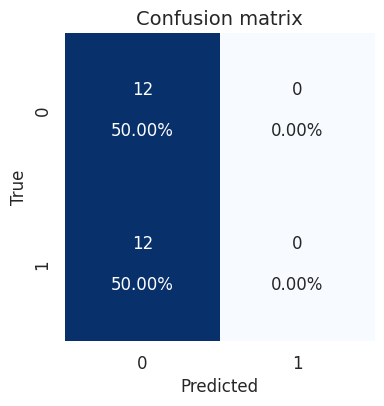

In [285]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

## SHAP (SHapley Additive exPlanations) - done for model 1 v1

In [286]:
shape = (train_X.shape[1],)
model = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())

In [287]:
explainer = shap.DeepExplainer(model, np.asarray(train_X))
shap_values = explainer.shap_values(np.asarray(train_X))

/opt/conda/lib/python3.7/site-packages/shap/explainers/_deep/deep_tf.py:102: UserWarning:

keras is no longer supported, please use tf.keras instead.

/opt/conda/lib/python3.7/site-packages/shap/explainers/_deep/deep_tf.py:107: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

/home/jupyter/.local/lib/python3.7/site-packages/keras/backend.py:452: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


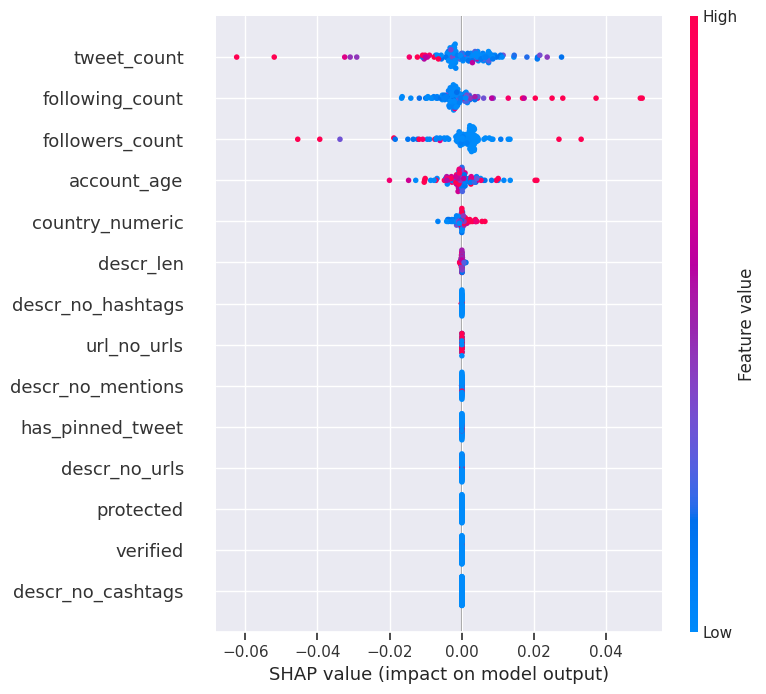

In [288]:
shap.summary_plot(shap_values[0], train_X, plot_type='dot')

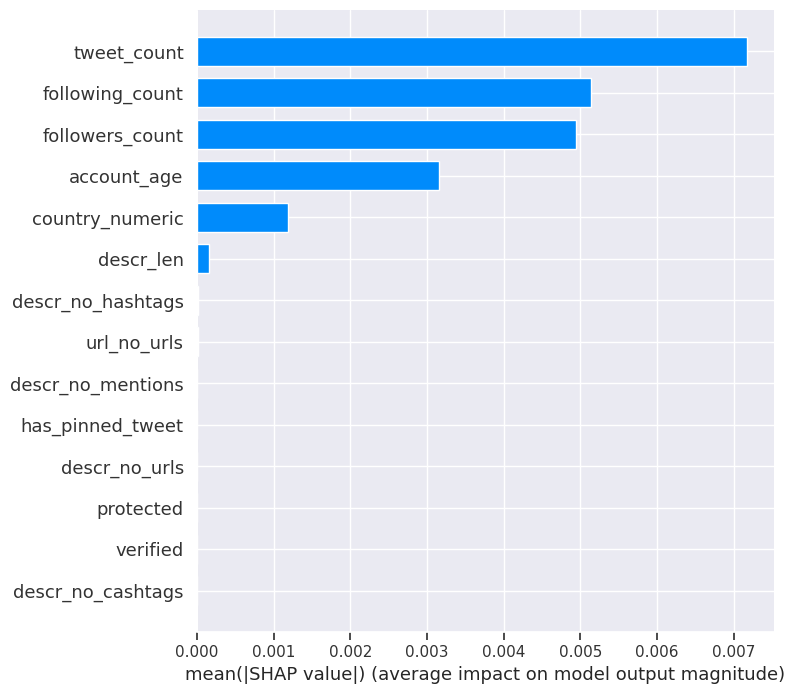

In [289]:
shap.summary_plot(shap_values[0], train_X, plot_type='bar')

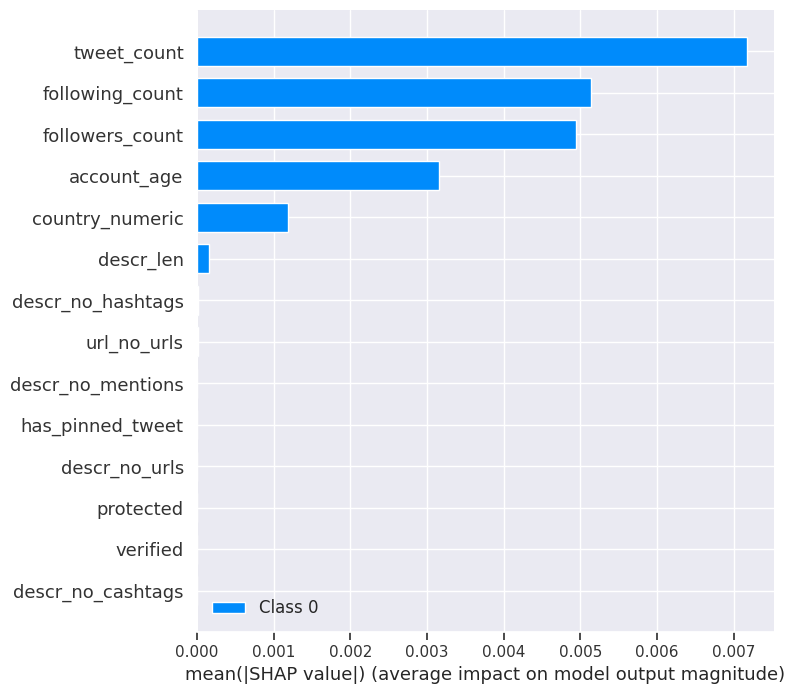

In [290]:
shap.summary_plot(shap_values, train_X, plot_type='bar')

In [184]:
# shap.dependence_plot("followers_count", shap_values[0],  train_X)